In [1]:
import cython
import numpy as np
import TidalPy
print(TidalPy.__version__)

0.5.0a5.dev11


In [2]:
%load_ext cython

In [3]:
import matplotlib.pyplot as plt

def plot_ys(radius_array, ys):
    
    # Skip Complex
    all_ys = ys.shape[0]
    num_ys = int(all_ys/2)
    ys_plot = np.empty((num_ys, ys.shape[1]), dtype=np.float64)
    j = 0
    for i in range(all_ys):
        if i % 2:
            ys_plot[j, :] = ys[i, :]
            j+=1
    
    if num_ys == 2:
        ncols = 2
        nrows = 1        
    elif num_ys == 4:
        ncols = 2
        nrows = 2
    else:
        ncols = 3
        nrows = 2
    fig, axes = plt.subplots(nrows=nrows, ncols=ncols)
    
    for i in range(nrows):
        for j in range(ncols):
            k = (i * ncols) + j
            axes[i, j].plot(radius_array/1000, ys[k, :])
    plt.show()

In [4]:
import numpy as np
from scipy.constants import G

from TidalPy.rheology.complex_compliance.compliance_models import newton, elastic, maxwell
from TidalPy.radial_solver.numerical.initial import find_initial_guess
from TidalPy.utilities.spherical_helper import calculate_mass_gravity_arrays
from TidalPy.radial_solver.nondimensional import non_dimensionalize_physicals

radius = np.linspace(0.1, 6.371e6, 50)
bulk_density = 5515.0
density = np.ones_like(radius) * bulk_density
shear_modulus = 50e9 * np.ones_like(radius)
viscosity = 1.0e18 * np.ones_like(radius)
bulk_modulus = np.ones_like(radius) * 100.0e9
G_to_use = G
order_l = 2
frequency = 2 * np.pi / (24 * 60 * 60)
complex_shear = maxwell(frequency, shear_modulus**(-1), viscosity)**(-1)

volume_array, mass_array, gravity = calculate_mass_gravity_arrays(radius, density, G_to_use)

use_non_dim = True
if use_non_dim:
    radius_prime, gravity_prime, density_prime, shear_modulus_prime, bulk_modulus_prime, frequency_prime, newton_g_prime = \
    non_dimensionalize_physicals(radius, gravity, density, complex_shear, bulk_modulus, frequency, radius[-1], bulk_density)
else:
    radius_prime = radius
    gravity_prime = gravity
    density_prime = density
    shear_modulus_prime = complex_shear
    bulk_modulus_prime = bulk_modulus
    frequency_prime = frequency
    newton_g_prime = G

init_guess = find_initial_guess(
        is_solid=False, is_static=False, is_incompressible=False, is_kamata=False,
        radius=radius_prime[0], shear_modulus=shear_modulus_prime[0], bulk_modulus=bulk_modulus_prime[0],
        density=density_prime[0], frequency=frequency_prime, order_l=order_l, G_to_use=newton_g_prime
    )

solutions = list()
for sol in init_guess:
    num_y = sol.size
    y0 = np.zeros(num_y*2, dtype=np.float64, order='C')
    for i in range(num_y):
        y0[2 * i] = np.real(sol[i])
        y0[2 * i + 1] = np.imag(sol[i])
    solutions.append(y0)

In [5]:
solutions

[array([1.661e-24, 0.000e+00, 3.264e-19, 0.000e+00, -3.264e-19, 0.000e+00,
        -1.040e-10, 0.000e+00]),
 array([3.139e-08, 0.000e+00, 0.000e+00, 0.000e+00, 6.559e-16, 0.000e+00,
        8.335e-08, 0.000e+00])]

In [6]:
frequency_prime

0.0676262910543706

In [39]:
%%cython --annotate --force
# distutils: language = c++
# cython: boundscheck=False, wraparound=False, nonecheck=False, cdivision=True, initializedcheck=False

import cython
cimport cython
import sys
import numpy as np
cimport numpy as np

np.import_array()

from libcpp cimport bool as bool_cpp_t
from libc.math cimport sqrt, fabs, nextafter, fmax, fmin, isnan, NAN, pow

from CyRK.array.interp cimport interp_array
from CyRK.rk.rk cimport (
    RK23_C, RK23_B, RK23_E, RK23_A, RK23_order, RK23_error_order, RK23_n_stages, RK23_LEN_C,
    RK45_C, RK45_B, RK45_E, RK45_A, RK45_order, RK45_error_order, RK45_n_stages, RK45_LEN_C,
    DOP_C_REDUCED, DOP_B, DOP_E3, DOP_E5, DOP_A_REDUCED, DOP_order, DOP_error_order, DOP_n_stages,
    DOP_n_stages_extended, DOP_LEN_C)

# # Integration Constants
# Multiply steps computed from asymptotic behaviour of errors by this.
cdef double SAFETY = 0.9
cdef double MIN_FACTOR = 0.2  # Minimum allowed decrease in a step size.
cdef double MAX_FACTOR = 10.  # Maximum allowed increase in a step size.
cdef double MAX_STEP = np.inf
cdef double INF = np.inf
cdef double EPS = np.finfo(np.float64).eps
cdef double EPS_10 = EPS * 10.
cdef double EPS_100 = EPS * 100.
cdef Py_ssize_t MAX_INT_SIZE = int(0.95 * sys.maxsize)

cdef (double, double) EMPTY_T_SPAN = (NAN, NAN)

# noinspection PyUnresolvedReferences
cdef class CySolver:
    """
    CySolver: A Object-Oriented Runge-Kutta Solver Implemented in Cython.

    This class provides basic functionality to solve systems of ordinary differential equations using a Runge-Kutta
    scheme. Users can cimport this extension and build their own solvers by overriding its diffeq and update_constants
    methods. Users can also expand on its __init__ or other methods for more complex problems.

    Class attributes are defined, with types, in cysolver.pxd.

    Note: "Time" is used throughout this class's variable names and documentation. It is a placeholder for the
    independent variable that the ODE's derivatives are taken with respect to. Instead of time it could be, for example,
    distance. We choose to use time as a generic placeholder term.

    Attributes
    ----------
    solution_y_view : double[:, ::1]
        Memoryview of final solution for dependent variables.
        See Also: The public property method, `CySolver.y`
    solution_extra_view : double[:, ::1]
        Memoryview of the final solution for any extra parameters captured during integration.
        See Also: The public property method, `CySolver.extra`
    solution_t_view : double[::1]
        Memoryview of the final independent domain found during integration.
        See Also: The public property method, `CySolver.t`
    y_size : Py_ssize_t
        Number of dependent variables in system of ODEs.
    y_size_dbl : double
        Floating point version of y_size.
    y_size_sqrt : double
        Square-root of y_size.
    y0_view : double[::1]
        Memoryview of dependent variable initial conditions (y0 at t_start).
    t_start : double
        Value of independent variable at beginning of integration (t0).
    t_end : double
        End value of independent variable.
    t_delta : double
        Independent variable domain for integration: t_end - t_start.
        t_delta may be negative or positive depending on if integration is forwards or backwards.
    t_delta_abs : double
        Absolute value of t_delta.
    direction_inf : double
        Direction of integration. If forward then this = +Inf; -Inf otherwise.
    direction_flag : bool_cpp_t
        If True, then integration is in the forward direction.
    num_args : Py_ssize_t
        Number of additional arguments that the `diffeq` method requires.
    arg_array_view double[::1]
        Memoryview of additional arguments used in the `diffeq` method.
    capture_extra bool_cpp_t
        Flag used if extra parameters should be captured during integration.
    num_extra Py_ssize_t
        Number of extra parameters that should be captured during integration.
    status : char; public
        Numerical flag to indicate status of integrator.
        See "Status and Error Codes.md" in the documentation for more information.
    message : str; public
        Verbal message to accompany `self.status` explaining the state (and potential errors) of the integrator.
    success : bool_cpp_t; public
        Flag indicating if the integration was successful or not.
    rtols_view : double[::1]
        Memoryview of relative tolerances for each dependent y variable.
    atols_view : double[::1]
        Memoryview of absolute tolerances for each dependent y variable.
    first_step : double
        Absolute size of the first step to be taken after t_start.
    max_step : double
        Maximum absolute step sized allowed.
    max_num_steps : Py_ssize_t
        Maximum number of steps allowed before integration auto fails.
    expected_size : Py_ssize_t
        Anticipated size of integration range, i.e., how many steps will be required.
        Used to build temporary storage arrays for the solution results.
    num_concats : Py_ssize_t
        Number of concatenations that were required during integration.
        If `expected_size` is too small then it will be expanded as needed. This variable tracks how many expansions
        were required.
        See Also: `CySolver.growths`
    recalc_first_step : bool_cpp_t
        If True, then the `first_step` size is recalculated when `reset_state` is called.
        Flag used when parameters are changed without reinitializing CySolver.
    run_interpolation : bool_cpp_t
        Flag if a final interpolation should be run once integration is completed successfully.
    interpolate_extra : bool_cpp_t
        Flag if interpolation should be run on extra parameters.
        If set to False when `run_interpolation=True`, then interpolation will be run on solution's y, t. These will
        then be used to recalculate extra parameters rather than an interpolation on the extra parameters captured
        during integration.
    len_t_eval : Py_ssize_t
        Length of user requested independent domain, `t_eval`.
    t_eval_view : double[::1]
        Memoryview of user requested independent domain, `t_eval`.
    rk_method : unsigned char
        Runge-Kutta method that will be used. Currently implemented models:
            0: ‘RK23’: Explicit Runge-Kutta method of order 3(2).
            1: ‘RK45’ (default): Explicit Runge-Kutta method of order 5(4).
            2: ‘DOP853’: Explicit Runge-Kutta method of order 8.
    rk_order : Py_ssize_t
        Runge-Kutta step power.
    error_order : Py_ssize_t
        Runge-Kutta error power.
    rk_n_stages : Py_ssize_t
        Number of Runge-Kutta stages performed for each RK step.
    rk_n_stages_plus1 : Py_ssize_t
        One more than `rk_n_stages`.
    rk_n_stages_extended : Py_ssize_t
        An extended version of `rk_n_stages` used for DOP853 method.
    error_expo : double
        Exponential used during error calculation. Utilizes `error_order`.
    len_C : Py_ssize_t
        Size of the RK C array.
    B_view : double[::1]
        Memoryview of the RK B parameter.
    E_view : double[::1]
        Memoryview of the RK E parameter.
    E3_view : double[::1]
        Memoryview of the RK E3 parameter.
    E5_view : double[::1]
        Memoryview of the RK E5 parameter.
    C_view : double[::1]
        Memoryview of the RK C parameter.
    A_view : double[:, ::1]
        Memoryview of the RK A parameter.
    K_view : double[:, ::1]
        Memoryview of the RK K parameter.
    K_T_view : double[:, ::1]
        Memoryview of the RK K parameter's transpose.
    t_new : double
        Current value of the independent variable used during integration.
    t_old : double
        Value of the independent variable at the previous step.
    step_size : double
        Current step's absolute size.
    len_t : Py_ssize_t
        Number of steps taken.
    y_new_view : double[::1]
        Current Memoryview of the dependent y variables.
    y_old_view : double[::1]
        Memoryview of the dependent y variables at the previous step.
    y_new_view : double[::1]
        Current Memoryview of dy/dt.
    y_old_view : double[::1]
        Memoryview of dy/dt at the previous step.
    extra_output_init_view : double[::1]
        Memoryview of extra outputs at the initial step (t=t0; y=y0).
        Extra outputs are parameters captured during diffeq calculation.
    extra_output_view : double[::1]
        Current Memoryview of extra outputs (at t_new).
        Extra outputs are parameters captured during diffeq calculation.

    Methods
    reset_state()
        Resets the class' state variables so that integration can be rerun.
    calc_first_step()
        Calculates the first step's size.
    rk_step()
        Performs a Runge-Kutta step calculation including local error determination.
    solve(reset=True)
        Public wrapper to the private solve method which calculates the integral of the user-provided system of ODEs.
        If reset=True, `reset_state()` will be called before integration starts.
    _solve()
        Calculates the integral of the user-provided system of ODEs.
        If reset=True, `reset_state()` will be called before integration starts.
    interpolate()
        Performs a final interpolation to fit solution results into a user requested independent variable domain.
    change_t_span(t_span, auto_reset_state=False)
        Public method to change the independent variable limits (start and stop points of integration).
    change_y0(y0, auto_reset_state=False)
        Public method to change the initial conditions.
    change_args(args, auto_reset_state=False)
        Public method to change additional arguments used during integration.
    change_tols(rtol=NAN, atol=NAN, rtols=None, atols=None, auto_reset_state=False)
        Public method to change relative and absolute tolerances and/or their arrays.
    change_max_step(max_step, auto_reset_state=False)
        Public method to change maximum allowed step size.
    change_first_step(first_step, auto_reset_state=False)
        Public method to change first step's size.
    change_t_eval(t_eval, auto_reset_state=False)
        Public method to change user requested independent domain, `t_eval`.
    change_parameters(*, auto_reset_state=True, auto_solve=False)
        Public method to change one or more parameters which have their own `change_*` method.
    update_constants()
        Method that is called during `reset_state` to change any constant parameters used by `diffeq`.
        This method is expected to be overriden by user constructed subclasses.
    diffeq()
        The system of differential equations that will be solved by the integrator.
        This method is expected to be overriden by user constructed subclasses.
    """
    # -- Solution variables
    cdef double[:, ::1] solution_y_view, solution_extra_view
    cdef double[::1] solution_t_view

    # -- Dependent (y0) variable information
    cdef Py_ssize_t y_size
    cdef double y_size_dbl, y_size_sqrt
    cdef const double[::1] y0_view

    # -- Time information
    cdef double t_start, t_end, t_delta, t_delta_abs, direction_inf
    cdef bool_cpp_t direction_flag

    # -- Optional args info
    cdef Py_ssize_t num_args
    cdef double[::1] arg_array_view

    # -- Extra output info
    cdef bool_cpp_t capture_extra
    cdef Py_ssize_t num_extra

    # -- Integration information
    cdef readonly char status
    cdef readonly str message
    cdef public bool_cpp_t success
    cdef double[::1] rtols_view, atols_view
    cdef double first_step, max_step
    cdef Py_ssize_t max_num_steps
    cdef Py_ssize_t expected_size, num_concats,
    cdef bool_cpp_t recalc_first_step

    # -- Interpolation info
    cdef bool_cpp_t run_interpolation
    cdef bool_cpp_t interpolate_extra
    cdef Py_ssize_t len_t_eval
    cdef double[::1] t_eval_view

    # -- RK method information
    cdef unsigned char rk_method
    cdef Py_ssize_t rk_order, error_order, rk_n_stages, rk_n_stages_plus1, rk_n_stages_extended
    cdef double error_expo
    cdef Py_ssize_t len_C
    cdef double[::1] B_view, E_view, E3_view, E5_view, C_view
    cdef double[:, ::1] A_view, K_view
    cdef double[::1, :] K_T_view

    # -- Live variables
    cdef double t_new, t_old, step_size
    cdef Py_ssize_t len_t
    cdef double[::1] y_new_view, y_old_view, dy_new_view, dy_old_view
    cdef double[::1] extra_output_init_view, extra_output_view

    def __init__(self,
            (double, double) t_span,
            const double[::1] y0,
            tuple args = None,
            double rtol = 1.e-3,
            double atol = 1.e-6,
            double[::1] rtols = None,
            double[::1] atols = None,
            unsigned char rk_method = 1,
            double max_step = MAX_STEP,
            double first_step = 0.,
            Py_ssize_t max_num_steps = 0,
            const double[::1] t_eval = None,
            bool_cpp_t capture_extra = False,
            Py_ssize_t num_extra = 0,
            bool_cpp_t interpolate_extra = False,
            Py_ssize_t expected_size = 0,
            bool_cpp_t auto_solve = True):
        """
        Initialize new CySolver instance.

        Parameters
        ----------
        t_span : (double, double)
            Values of independent variable at beginning and end of integration.
        y0 : double[::1]
            Initial values for the dependent y variables at `t_span[0]`.
        args : tuple or None, default=None
            Additional arguments used by the differential equation.
            None (default) will tell the solver to not use additional arguments.
        rk_method : int, default=1
            Runge-Kutta method that will be used. Currently implemented models:
                0: ‘RK23’: Explicit Runge-Kutta method of order 3(2).
                1: ‘RK45’ (default): Explicit Runge-Kutta method of order 5(4).
                2: ‘DOP853’: Explicit Runge-Kutta method of order 8.
        rtol : double, default=1.0e-3
            Relative tolerance using in local error calculation.
        atol : double, default=1.0e-6
            Absolute tolerance using in local error calculation.
        rtols : double[::1], default=None
            np.ndarray of relative tolerances, one for each dependent y variable.
            None (default) will use the same tolerance (set by `rtol`) for each y variable.
        atols : double[::1], default=None
            np.ndarray of absolute tolerances, one for each dependent y variable.
            None (default) will use the same tolerance (set by `atol`) for each y variable.
        max_step : double, default=+Inf
            Maximum allowed step size.
        first_step : double, default=0
            First step's size (after `t_span[0]`).
            If set to 0 (the default) then the solver will attempt to guess a suitable initial step size.
        max_num_steps : Py_ssize_t, default=0
            Maximum number of step sizes allowed before solver will auto fail.
            If set to 0 (the default) then the maximum number of steps will be equal to max integer size
            allowed on system architecture.
        t_eval : double[::1], default=None
            If not set to None, then a final interpolation will be performed on the solution to fit it to this array.
        capture_extra : bool = False
            If True, then additional output from the differential equation will be collected (but not used to determine
             integration error).
             Example:
                ```
                def diffeq(t, y, dy):
                    a = ... some function of y and t.
                    dy[0] = a**2 * sin(t) - y[1]
                    dy[1] = a**3 * cos(t) + y[0]

                    # Storing extra output in dy even though it is not part of the diffeq.
                    dy[2] = a
                ```
        num_extra : int = 0
            The number of extra outputs the integrator should expect. With the previous example there is 1 extra output.
        interpolate_extra : bool_cpp_t, default=False
            Flag if interpolation should be run on extra parameters.
            If set to False when `run_interpolation=True`, then interpolation will be run on solution's y, t. These will
            then be used to recalculate extra parameters rather than an interpolation on the extra parameters captured
            during integration.
        expected_size : Py_ssize_t, default=0
            Anticipated size of integration range, i.e., how many steps will be required.
            Used to build temporary storage arrays for the solution results.
            If set to 0 (the default), then the solver will attempt to guess on a suitable expected size based on the
            relative tolerances and size of the integration domain.
        auto_solve : bool_cpp_t, default=True
            If set to True, then the solver's `solve` method will be called at the end of initialization.
            Otherwise, the user will have to call `solver_instance = CySolver(...); solver_instance.solve()`
            to perform integration.
        """

        # Loop variables
        cdef Py_ssize_t i, j

        # Set integration information
        self.status  = -4  # Status code to indicate that integration has not started.
        self.message = 'Integration has not started.'
        self.success = False
        self.recalc_first_step = False

        # Store y0 values and determine y-size information
        self.y0_view     = y0
        self.y_size      = self.y0_view.size
        self.y_size_dbl  = <double>self.y_size
        self.y_size_sqrt = sqrt(self.y_size_dbl)

        # Determine time domain information
        self.t_start = t_span[0]
        self.t_end   = t_span[1]
        self.t_delta = self.t_end - self.t_start
        if self.t_delta >= 0.:
            # Integration is moving forward in time.
            self.direction_flag = True
            self.direction_inf  = INF
            self.t_delta_abs    = self.t_delta
        else:
            # Integration is moving backwards in time.
            self.direction_flag = False
            self.direction_inf  = -INF
            self.t_delta_abs    = -self.t_delta

        # Determine integration tolerances
        cdef double rtol_tmp
        cdef np.ndarray[np.float64_t, ndim=1, mode='c'] rtol_array, atol_array
        rtol_array = np.empty(self.y_size, dtype=np.float64, order='C')
        atol_array = np.empty(self.y_size, dtype=np.float64, order='C')
        self.rtols_view = rtol_array
        self.atols_view = atol_array

        if rtols is not None:
            # User provided an arrayed version of rtol.
            if len(rtols) != self.y_size:
                raise AttributeError('rtol array must be the same size as y0.')
            for i in range(self.y_size):
                rtol_tmp = rtols[i]
                # Check that the tolerances are not too small.
                if rtol_tmp < EPS_100:
                    rtol_tmp = EPS_100
                self.rtols_view[i] = rtol_tmp
        else:
            # No array provided. Use the same rtol for all ys.
            # Check that the tolerances are not too small.
            if rtol < EPS_100:
                rtol = EPS_100
            for i in range(self.y_size):
                self.rtols_view[i] = rtol

        if atols is not None:
            # User provided an arrayed version of atol.
            if len(atols) != self.y_size:
                raise AttributeError('atol array must be the same size as y0.')
            for i in range(self.y_size):
                self.atols_view[i] = atols[i]
        else:
            # No array provided. Use the same atol for all ys.
            for i in range(self.y_size):
                self.atols_view[i] = atol

        # Determine maximum number of steps
        if max_num_steps == 0:
            self.max_num_steps = MAX_INT_SIZE
        elif max_num_steps < 0:
            self.status = -8
            self.message = "Attribute error."
            raise AttributeError('Negative number of max steps provided.')
        else:
            self.max_num_steps = min(max_num_steps, MAX_INT_SIZE)

        # Expected size of output arrays.
        cdef double temp_expected_size
        if expected_size == 0:
            # CySolver will attempt to guess on a best size for the arrays.
            temp_expected_size = 100. * self.t_delta_abs * fmax(1., (1.e-6 / rtol))
            temp_expected_size = fmax(temp_expected_size, 100.)
            temp_expected_size = fmin(temp_expected_size, 10_000_000.)
            self.expected_size = <Py_ssize_t>temp_expected_size
        else:
            self.expected_size = <Py_ssize_t>expected_size
        # This variable tracks how many times the storage arrays have been appended.
        # It starts at 1 since there is at least one storage array present.
        self.num_concats = 1

        # Determine optional arguments
        cdef np.ndarray[np.float64_t, ndim=1, mode='c'] arg_array
        if args is None:
            self.num_args = 0
            # Even though there are no args, initialize the array to something to avoid seg faults
            arg_array = np.empty(0, dtype=np.float64, order='C')
            self.arg_array_view = arg_array
        else:
            self.num_args = len(args)
            arg_array = np.empty(self.num_args, dtype=np.float64, order='C')
            self.arg_array_view = arg_array
            for i in range(self.num_args):
                self.arg_array_view[i] = args[i]

        # Initialize live variable arrays
        cdef np.ndarray[np.float64_t, ndim=1, mode='c'] y_new, y_old, dy_new, dy_old
        y_new  = np.empty(self.y_size, dtype=np.float64, order='C')
        y_old  = np.empty(self.y_size, dtype=np.float64, order='C')
        dy_new = np.empty(self.y_size, dtype=np.float64, order='C')
        dy_old = np.empty(self.y_size, dtype=np.float64, order='C')
        self.y_new_view  = y_new
        self.y_old_view  = y_old
        self.dy_new_view = dy_new
        self.dy_old_view = dy_old

        # Determine extra outputs
        cdef np.ndarray[np.float64_t, ndim=1, mode='c'] extra_output_init, extra_output
        self.capture_extra = capture_extra
        # To avoid memory access violations we need to set the extra output arrays no matter if they are used.
        # If not used, just set them to size zero.
        if self.capture_extra:
            if num_extra == 0:
                self.status = -8
                raise AttributeError('Capture extra set to True, but number of extra set to 0.')
            self.num_extra = num_extra
        else:
            self.num_extra = 0
        extra_output_init = np.empty(self.num_extra, dtype=np.float64, order='C')
        extra_output      = np.empty(self.num_extra, dtype=np.float64, order='C')
        self.extra_output_init_view = extra_output_init
        self.extra_output_view      = extra_output

        # Determine interpolation information
        cdef np.ndarray[np.float64_t, ndim=1, mode='c'] t_eval_array
        if t_eval is None:
            self.run_interpolation = False
            self.interpolate_extra = False
            self.len_t_eval = 0
        else:
            self.run_interpolation = True
            self.interpolate_extra = interpolate_extra
            self.len_t_eval = len(t_eval)

            t_eval_array = np.empty(self.len_t_eval, dtype=np.float64, order='C')
            self.t_eval_view = t_eval_array
            for i in range(self.len_t_eval):
                self.t_eval_view[i] = t_eval[i]

        # Determine RK scheme and initialize RK memory views
        self.rk_method = rk_method
        if rk_method == 0:
            # RK23 Method
            self.rk_order    = RK23_order
            self.error_order = RK23_error_order
            self.rk_n_stages = RK23_n_stages
            self.len_C       = RK23_LEN_C
            self.A_view  = RK23_A
            self.B_view  = RK23_B
            self.C_view  = RK23_C
            self.E_view  = RK23_E

            # Unused for RK23 but initalize it anyways
            self.E3_view = RK23_E
            self.E5_view = RK23_E
        elif rk_method == 1:
            # RK45 Method
            self.rk_order    = RK45_order
            self.error_order = RK45_error_order
            self.rk_n_stages = RK45_n_stages
            self.len_C       = RK45_LEN_C
            self.A_view  = RK45_A
            self.B_view  = RK45_B
            self.C_view  = RK45_C
            self.E_view  = RK45_E

            # Unused for RK23 but initalize it anyways
            self.E3_view = RK45_E
            self.E5_view = RK45_E
        elif rk_method == 2:
            # DOP853 Method
            self.rk_order    = DOP_order
            self.error_order = DOP_error_order
            self.rk_n_stages = DOP_n_stages
            self.len_C       = DOP_LEN_C
            self.A_view  = DOP_A_REDUCED
            self.B_view  = DOP_B
            self.C_view  = DOP_C_REDUCED
            self.E3_view = DOP_E3
            self.E5_view = DOP_E5
            self.rk_n_stages_extended = DOP_n_stages_extended

            # Unused for DOP853 but initialize it anyways
            self.E_view  = DOP_E3
        else:
            self.status = -8
            self.message = "Attribute error."
            raise AttributeError(
                'Unexpected rk_method provided. Currently supported versions are:\n'
                '\t0 = RK23\n'
                '\t1 = RK34\n'
                '\t2 = DOP853')

        self.rk_n_stages_plus1 = self.rk_n_stages + 1
        self.error_expo        = 1. / (<double>self.error_order + 1.)

        # Initialize other RK-related Arrays
        cdef np.ndarray[np.float64_t, ndim=2, mode='c'] K
        # It is important K be initialized with 0s
        K = np.zeros((self.rk_n_stages_plus1, self.y_size), dtype=np.float64, order='C')
        self.K_view   = K
        self.K_T_view = self.K_view.T

        # Store user provided step information
        self.first_step = first_step
        self.max_step   = max_step

        # Parameters are initialized but may not be set to correct values.
        # Call reset state to ensure everything is ready.
        self.reset_state()

        # Run solver if requested
        if auto_solve:
            # We know for a fact that this is the first time solve will be called and we just reset the Sovler's state
            # So we can safely tell the solve method not to reset.
            self._solve(reset=False)


    cpdef void reset_state(self):
        """ Resets the class' state variables so that integration can be rerun. """
        cdef Py_ssize_t i, j

        # Set current and old time variables equal to t0
        self.t_old = self.t_start
        self.t_new = self.t_start
        self.len_t = 1

        # Reset y variables back to initial conditions
        for i in range(self.y_size):
            # Set current and old y variables equal to y0
            self.y_new_view[i] = self.y0_view[i]
            self.y_old_view[i] = self.y0_view[i]

            for j in range(self.rk_n_stages_plus1):
                # Reset RK variables
                self.K_view[j, i] = 0.

        # Update any constant parameters that the user has set
        self.update_constants()

        # Make initial call to diffeq()
        self.diffeq()

        # Store first dydt
        for i in range(self.y_size):
            self.dy_old_view[i] = self.dy_new_view[i]

        # Store extra outputs for the first time step
        if self.capture_extra:
            for i in range(self.num_extra):
                self.extra_output_init_view[i] = self.extra_output_view[i]

        # Determine first step's size
        if self.first_step == 0. or self.recalc_first_step:
            self.step_size = self.calc_first_step()
        else:
            if self.first_step <= 0.:
                self.status = -8
                self.message = "Attribute error."
                raise AttributeError('Error in user-provided step size: Step size must be a positive number.')
            elif self.first_step > self.t_delta_abs:
                self.status = -8
                self.message = "Attribute error."
                raise AttributeError('Error in user-provided step size: Step size can not exceed bounds.')
            self.step_size = self.first_step

        # Reset output storage
        self.num_concats = 1

        # Reset public variables to clear any old solutions
        # and to avoid memory access violations if solve() is not called.
        cdef np.ndarray[np.float64_t, ndim=2, mode='c'] solution_extra_fake, solution_y_fake
        cdef np.ndarray[np.float64_t, ndim=1, mode='c'] solution_t_fake
        solution_extra_fake = np.nan * np.ones((1, 1), dtype=np.float64, order='C')
        solution_y_fake     = np.nan * np.ones((1, 1), dtype=np.float64, order='C')
        solution_t_fake     = np.nan * np.ones(1, dtype=np.float64, order='C')
        self.solution_t_view     = solution_t_fake
        self.solution_extra_view = solution_extra_fake
        self.solution_y_view     = solution_y_fake

        # Other integration flags and messages
        self.success = False
        self.status = -5  # status == -5 means that reset has been called but solve has not yet been called.
        self.message = "CySolver has been reset."


    cdef double calc_first_step(self) noexcept nogil:
        """
        Select an initial step size based on the differential equation.
        .. [1] E. Hairer, S. P. Norsett G. Wanner, "Solving Ordinary Differential
               Equations I: Nonstiff Problems", Sec. II.4.
        """

        cdef double step_size, d0, d1, d2, d0_abs, d1_abs, d2_abs, h0, h1, scale
        cdef double y_old_tmp

        if self.y_size == 0:
            step_size = INF
        else:
            # Find the norm for d0 and d1
            d0 = 0.
            d1 = 0.
            for i in range(self.y_size):
                y_old_tmp = self.y_old_view[i]

                scale = self.atols_view[i] + fabs(y_old_tmp) * self.rtols_view[i]

                d0_abs = fabs(y_old_tmp / scale)
                d1_abs = fabs(self.dy_old_view[i] / scale)
                d0 += (d0_abs * d0_abs)
                d1 += (d1_abs * d1_abs)

            d0 = sqrt(d0) / self.y_size_sqrt
            d1 = sqrt(d1) / self.y_size_sqrt

            if d0 < 1.e-5 or d1 < 1.e-5:
                h0 = 1.e-6
            else:
                h0 = 0.01 * d0 / d1

            if self.direction_flag:
                h0_direction = h0
            else:
                h0_direction = -h0

            self.t_new = self.t_old + h0_direction
            for i in range(self.y_size):
                self.y_new_view[i] = self.y_old_view[i] + h0_direction * self.dy_old_view[i]

            # Update dy_new_view
            self.diffeq()

            # Find the norm for d2
            d2 = 0.
            for i in range(self.y_size):

                scale = self.atols_view[i] + fabs(self.y_old_view[i]) * self.rtols_view[i]
                d2_abs = fabs( (self.dy_new_view[i] - self.dy_old_view[i]) / scale)
                d2 += (d2_abs * d2_abs)

            d2 = sqrt(d2) / (h0 * self.y_size_sqrt)

            if d1 <= 1.e-15 and d2 <= 1.e-15:
                h1 = max(1.e-6, h0 * 1.e-3)
            else:
                h1 = (0.01 / max(d1, d2))**self.error_expo

            step_size = max(10. * fabs(nextafter(self.t_old, self.direction_inf) - self.t_old),
                            min(100. * h0, h1))

        return step_size


    cdef void rk_step(self) noexcept nogil:
        """ Performs a Runge-Kutta step calculation including local error determination. """

        # Initialize step variables
        cdef Py_ssize_t s, i, j
        cdef double min_step, step, step_factor, time_tmp, t_delta_check
        cdef double scale, K_scale, dy_tmp
        cdef double error_norm3, error_norm5, error_norm, error_dot_1, error_dot_2, error_denom, error_pow
        cdef bool_cpp_t step_accepted, step_rejected, step_error

        # Run RK integration step
        # Determine step size based on previous loop
        # Find minimum step size based on the value of t (less floating point numbers between numbers when t is large)
        min_step = 10. * fabs(nextafter(self.t_old, self.direction_inf) - self.t_old)
        # Look for over/undershoots in previous step size
        if self.step_size > self.max_step:
            self.step_size = self.max_step
        elif self.step_size < min_step:
            self.step_size = min_step

        # Determine new step size
        step_accepted = False
        step_rejected = False
        step_error    = False

        # Optimization variables
        cdef double C_at_s, A_at_sj, A_at_10, B_at_j
        # Define a very specific A now since it is called consistently and does not change.
        A_at_10 = self.A_view[1, 0]

        # # Step Loop
        while not step_accepted:
            if self.step_size < min_step:
                step_error  = True
                self.status = -1
                break

            # Move time forward for this particular step size
            if self.direction_flag:
                step = self.step_size
                self.t_new = self.t_old + step
                t_delta_check = self.t_new - self.t_end
            else:
                step = -self.step_size
                self.t_new = self.t_old + step
                t_delta_check = self.t_end - self.t_new

            # Check that we are not at the end of integration with that move
            if t_delta_check > 0.:
                self.t_new = self.t_end

                # If we are, correct the step so that it just hits the end of integration.
                step = self.t_new - self.t_old
                if self.direction_flag:
                    self.step_size = step
                else:
                    self.step_size = -step

            # # Calculate derivative using RK method

            # t_new must be updated for each loop of s in order to make the diffeq calls.
            # But we need to return to its original value later on. Store in temp variable.
            time_tmp = self.t_new

            for s in range(1, self.len_C):
                C_at_s = self.C_view[s]

                # Update t_new so it can be used in the diffeq call.
                self.t_new = self.t_old + C_at_s * step

                # Dot Product (K, a) * step
                if s == 1:
                    for i in range(self.y_size):
                        # Set the first column of K
                        dy_tmp = self.dy_old_view[i]
                        self.K_view[0, i] = dy_tmp

                        # Calculate y_new for s==1
                        self.y_new_view[i] = self.y_old_view[i] + (dy_tmp * A_at_10 * step)
                else:
                    for j in range(s):
                        A_at_sj = self.A_view[s, j]
                        for i in range(self.y_size):
                            if j == 0:
                                # Initialize
                                self.y_new_view[i] = self.y_old_view[i]

                            self.y_new_view[i] += self.K_view[j, i] * A_at_sj * step

                # Call diffeq to update K with the new dydt
                self.diffeq()

                for i in range(self.y_size):
                    self.K_view[s, i] = self.dy_new_view[i]

            # Restore t_new to its previous value.
            self.t_new = time_tmp

            # Dot Product (K, B) * step
            for j in range(self.rk_n_stages):
                B_at_j = self.B_view[j]
                # We do not use rk_n_stages_plus1 here because we are chopping off the last row of K to match
                #  the shape of B.
                for i in range(self.y_size):
                    if j == 0:
                        # Initialize
                        self.y_new_view[i] = self.y_old_view[i]

                    self.y_new_view[i] += self.K_view[j, i] * B_at_j * step

            self.diffeq()

            # Check how well this step performed by calculating its error
            if self.rk_method == 2:
                # Calculate Error for DOP853
                # Dot Product (K, E5) / scale and Dot Product (K, E3) * step / scale
                error_norm3 = 0.
                error_norm5 = 0.
                for i in range(self.y_size):
                    # Find scale of y for error calculations
                    scale = (self.atols_view[i] +
                             max(fabs(self.y_old_view[i]), fabs(self.y_new_view[i])) * self.rtols_view[i])

                    # Set last array of K equal to dydt
                    self.K_view[self.rk_n_stages, i] = self.dy_new_view[i]
                    for j in range(self.rk_n_stages_plus1):
                        if j == 0:
                            # Initialize
                            error_dot_1 = 0.
                            error_dot_2 = 0.

                        K_scale = self.K_T_view[i, j] / scale
                        error_dot_1 += K_scale * self.E3_view[j]
                        error_dot_2 += K_scale * self.E5_view[j]

                    # We need the absolute value but since we are taking the square, it is guaranteed to be positive.
                    # TODO: This will need to change if CySolver ever accepts complex numbers
                    # error_norm3_abs = fabs(error_dot_1)
                    # error_norm5_abs = fabs(error_dot_2)

                    error_norm3 += (error_dot_1 * error_dot_1)
                    error_norm5 += (error_dot_2 * error_dot_2)

                # Check if errors are zero
                if (error_norm5 == 0.) and (error_norm3 == 0.):
                    error_norm = 0.
                else:
                    error_denom = error_norm5 + 0.01 * error_norm3
                    error_norm = self.step_size * error_norm5 / sqrt(error_denom * self.y_size_dbl)

            else:
                # Calculate Error for RK23 and RK45
                # Dot Product (K, E) * step / scale
                error_norm = 0.
                for i in range(self.y_size):
                    # Find scale of y for error calculations
                    scale = (self.atols_view[i] +
                             max(fabs(self.y_old_view[i]), fabs(self.y_new_view[i])) * self.rtols_view[i])

                    # Set last array of K equal to dydt
                    self.K_view[self.rk_n_stages, i] = self.dy_new_view[i]
                    for j in range(self.rk_n_stages_plus1):
                        if j == 0:
                            # Initialize
                            error_dot_1 = 0.

                        K_scale = self.K_T_view[i, j] / scale
                        error_dot_1 += K_scale * self.E_view[j] * step

                    # We need the absolute value but since we are taking the square, it is guaranteed to be positive.
                    # TODO: This will need to change if CySolver ever accepts complex numbers
                    # error_norm_abs = fabs(error_dot_1)

                    error_norm += (error_dot_1 * error_dot_1)
                error_norm = sqrt(error_norm) / self.y_size_sqrt

            if error_norm < 1.:
                # The error is low! Let's update this step for the next time loop
                if error_norm == 0.:
                    step_factor = MAX_FACTOR
                else:
                    error_pow = pow(error_norm, -self.error_expo)
                    step_factor = min(MAX_FACTOR, SAFETY * error_pow)

                if step_rejected:
                    # There were problems with this step size on the previous step loop. Make sure factor does
                    #    not exasperate them.
                    step_factor = min(step_factor, 1.)

                self.step_size = self.step_size * step_factor
                step_accepted = True
            else:
                error_pow = pow(error_norm, -self.error_expo)
                self.step_size = self.step_size * max(MIN_FACTOR, SAFETY * error_pow)
                step_rejected = True

        if step_error:
            # Issue with step convergence
            self.status = -1
        elif not step_accepted:
            # Issue with step convergence
            self.status = -7

        # End of step loop. Update the 'old' variables
        self.t_old = self.t_new
        for i in range(self.y_size):
            self.y_old_view[i]  = self.y_new_view[i]
            self.dy_old_view[i] = self.dy_new_view[i]


    cpdef void solve(self, bool_cpp_t reset = True):
        """
        Public wrapper to the private solve method which calculates the integral of the user-provided system of ODEs.
        
        Parameters
        ----------
        reset : bool_cpp_t, default=True
            If True, `reset_state()` will be called before integration starts.
        """
        self._solve(reset=reset)


    cdef void _solve(self, bool_cpp_t reset = True):
        """
        Calculates the integral of the user-provided system of ODEs.
        
        Parameters
        ----------
        reset : bool_cpp_t, default=True
            If True, `reset_state()` will be called before integration starts.
        """

        # Reset the solver's state (avoid issues if solve() is called multiple times).
        if reset:
            self.reset_state()

        # Setup loop variables
        cdef Py_ssize_t i, j

        # Setup storage arrays
        # These arrays are built to fit a number of points equal to `self.expected_size`
        # If the integration needs more than that then a new array will be concatenated (with performance costs) to these.
        cdef np.ndarray[np.float64_t, ndim=2, mode='c'] y_results_array, extra_array
        cdef np.ndarray[np.float64_t, ndim=1, mode='c'] time_domain_array
        cdef double[:, ::1] y_results_array_view, extra_array_view
        cdef double[::1] time_domain_array_view
        y_results_array        = np.empty((self.y_size, self.expected_size), dtype=np.float64, order='C')
        time_domain_array      = np.empty(self.expected_size, dtype=np.float64, order='C')
        y_results_array_view   = y_results_array
        time_domain_array_view = time_domain_array
        if self.capture_extra:
            extra_array      = np.empty((self.num_extra, self.expected_size), dtype=np.float64, order='C')
            extra_array_view = extra_array

        # The following are unused unless the previous array size is too small to capture all of the data
        cdef np.ndarray[np.float64_t, ndim=2, mode='c'] y_results_array_new, extra_array_new
        cdef np.ndarray[np.float64_t, ndim=1, mode='c'] time_domain_array_new
        cdef double[:, ::1] y_results_array_new_view, extra_array_new_view
        cdef double[::1] time_domain_array_new_view

        # Load initial conditions into output arrays
        time_domain_array_view[0] = self.t_start
        for i in range(self.y_size):
            y_results_array_view[i, 0] = self.y0_view[i]
        if self.capture_extra:
            for i in range(self.num_extra):
                extra_array_view[i, 0] = self.extra_output_init_view[i]

        # # Main integration loop
        self.status = 0

        if self.y_size == 0:
            self.status = -6

        while self.status == 0:

            # Check that integration is not complete.
            if self.t_new == self.t_end:
                self.t_old = self.t_end
                self.status = 1
                break

            # Check that maximum number of steps has not been exceeded.
            if self.len_t > self.max_num_steps:
                if self.max_num_steps == MAX_INT_SIZE:
                    self.status = -3
                else:
                    self.status = -2
                break

            # # Perform RK Step
            self.rk_step()

            # Check if an error occurred during step calculations before storing data.
            if self.status != 0:
                break

            # Store data
            if self.len_t >= (self.num_concats * self.expected_size):
                # There is more data then we have room in our arrays.
                # Build new arrays with more space.
                # OPT: Note this is an expensive operation.
                self.num_concats += 1
                new_size = self.num_concats * self.expected_size

                time_domain_array_new = np.empty(new_size, dtype=np.float64, order='C')
                y_results_array_new   = np.empty((self.y_size, new_size), dtype=np.float64, order='C')
                time_domain_array_new_view = time_domain_array_new
                y_results_array_new_view   = y_results_array_new
                if self.capture_extra:
                    extra_array_new = np.empty((self.num_extra, new_size), dtype=np.float64, order='C')
                    extra_array_new_view = extra_array_new

                # Fill in these new arrays with the old values (new values will be added later)
                for j in range(self.y_size):
                    for i in range(self.len_t):
                        if j == 0:
                            time_domain_array_new_view[i] = time_domain_array_view[i]
                        y_results_array_new_view[j, i] = y_results_array_view[j, i]

                if self.capture_extra:
                    for j in range(self.num_extra):
                        for i in range(self.len_t):
                            extra_array_new_view[j, i] = extra_array_view[j, i]

                # No longer need the old arrays. Change where the memory-views are pointing
                y_results_array_view = y_results_array_new
                time_domain_array_view = time_domain_array_new
                # TODO: Delete the old arrays?
                if self.capture_extra:
                    extra_array_view = extra_array_new

            # There is room to add this step's results to our storage arrays.
            time_domain_array_view[self.len_t] = self.t_new
            # To match the format that scipy follows, we will take the transpose of y.
            for i in range(self.y_size):
                y_results_array_view[i, self.len_t] = self.y_new_view[i]

            if self.capture_extra:
                for i in range(self.num_extra):
                    extra_array_view[i, self.len_t] = self.extra_output_view[i]

            # Increase number of independent variable points.
            self.len_t += 1

        # Integration has stopped. Check if it was successful.
        if self.status == 1:
            self.success = True
        else:
            self.success = False

        # Create output arrays. To match the format that scipy follows, we will take the transpose of y.
        cdef np.ndarray[np.float64_t, ndim=2, mode='c'] y_results_out_array, y_results_out_array_bad
        cdef np.ndarray[np.float64_t, ndim=2, mode='c'] extra_output_out_array, extra_output_out_array_bad
        cdef np.ndarray[np.float64_t, ndim=1, mode='c'] time_domain_out_array, time_domain_out_array_bad

        if self.success:
            # Load values into output arrays.
            # The arrays built during integration likely have a bunch of unused junk at the end due to overbuilding their size.
            # This process will remove that junk and leave only the valid data.
            y_results_out_array = np.empty((self.y_size, self.len_t), dtype=np.float64, order='C')
            time_domain_out_array = np.empty(self.len_t, dtype=np.float64, order='C')
            if self.capture_extra:
                extra_output_out_array = np.empty((self.num_extra, self.len_t), dtype=np.float64, order='C')

            # Link memory views
            self.solution_y_view = y_results_out_array
            self.solution_t_view = time_domain_out_array
            if self.capture_extra:
                self.solution_extra_view = extra_output_out_array

            # Populate values
            for j in range(self.y_size):
                for i in range(self.len_t):
                    # Since this loop is only going to len_t, it will cut off any extraneous data the storage arrays
                    # hold beyond that point.
                    if j == 0:
                        self.solution_t_view[i] = time_domain_array_view[i]
                    self.solution_y_view[j, i] = y_results_array_view[j, i]
            if self.capture_extra:
                for j in range(self.num_extra):
                    for i in range(self.len_t):
                        self.solution_extra_view[j, i] = extra_array_view[j, i]
        else:
            # Integration was not successful. But we still need to build solution arrays so that accessing the solution
            # will not cause access violations.
            # Build nan arrays
            y_results_out_array_bad   = np.nan * np.ones((self.y_size, 1), dtype=np.float64, order='C')
            time_domain_out_array_bad = np.nan * np.ones(1, dtype=np.float64, order='C')
            if self.capture_extra:
                extra_output_out_array_bad = np.nan * np.ones((self.num_extra, 1), dtype=np.float64, order='C')

            # Link memory views
            self.solution_y_view = y_results_out_array_bad
            self.solution_t_view = time_domain_out_array_bad
            if self.capture_extra:
                self.solution_extra_view = extra_output_out_array_bad

        # Integration is complete. Check if interpolation was requested.
        if self.success and self.run_interpolation:
            self.interpolate()

        # Update integration message
        if self.status == 1:
            self.message = "Integration completed without issue."
        elif self.status == 0:
            self.message = "Integration is/was ongoing (perhaps it was interrupted?)."
        elif self.status == -1:
            self.message = "Error in step size calculation:\n\tRequired step size is less than spacing between numbers."
        elif self.status == -2:
            self.message = "Maximum number of steps (set by user) exceeded during integration."
        elif self.status == -3:
            self.message = "Maximum number of steps (set by system architecture) exceeded during integration."
        elif self.status == -6:
            self.message = "Integration never started: y-size is zero."
        elif self.status == -7:
             self.message = "Error in step size calculation:\n\tError in step size acceptance."


    cdef void interpolate(self):
        """ Interpolate the results of a successful integration over the user provided time domain, `t_eval`. """
        # User only wants data at specific points.
        cdef char old_status
        old_status = self.status
        self.status = 2  # Interpolation is being performed.

        # Setup loop variables
        cdef Py_ssize_t i, j

        # TODO: The current version of CySolver has not implemented sicpy's dense output. Instead we use an interpolation.
        cdef np.ndarray[np.float64_t, ndim=2, mode='c'] y_results_reduced
        cdef np.ndarray[np.float64_t, ndim=1, mode='c'] y_result_timeslice, y_result_temp
        y_results_reduced  = np.empty((self.y_size, self.len_t_eval), dtype=np.float64, order='C')
        y_result_timeslice = np.empty(self.len_t, dtype=np.float64, order='C')
        y_result_temp      = np.empty(self.len_t_eval, dtype=np.float64, order='C')

        cdef double[:, ::1] y_results_reduced_view
        cdef double[::1] y_result_timeslice_view, y_result_temp_view
        y_results_reduced_view  = y_results_reduced
        y_result_timeslice_view = y_result_timeslice
        y_result_temp_view      = y_result_temp

        # Create arrays for extra output which may or may not be required.
        cdef np.ndarray[np.float64_t, ndim=2, mode='c'] extra_reduced
        cdef np.ndarray[np.float64_t, ndim=1, mode='c'] extra_timeslice, extra_temp
        cdef double[:, ::1] extra_reduced_view
        cdef double[::1] extra_timeslice_view, extra_temp_view

        for j in range(self.y_size):
            # The interpolation function only works on 1D arrays, so we must loop through each of the y variables.
            # # Set timeslice equal to the time values at this y_j
            for i in range(self.len_t):
                y_result_timeslice_view[i] = self.solution_y_view[j, i]

            # Perform numerical interpolation
            interp_array(
                self.t_eval_view,
                self.solution_t_view,
                y_result_timeslice_view,
                y_result_temp_view
                )

            # Store result.
            for i in range(self.len_t_eval):
                y_results_reduced_view[j, i] = y_result_temp_view[i]

        if self.capture_extra:
            # Right now if there is any extra output then it is stored at each time step used in the RK loop.
            # We have to make a choice:
            #   - Do we interpolate the extra values that were stored?
            #   - Or do we use the interpolated t, y values to find new extra parameters at those specific points.
            # The latter method is more computationally expensive (recalls the diffeq for each y) but is more accurate.
            # This decision is set by the user with the `interpolate_extra` flag.

            # Create extra output arrays
            extra_reduced   = np.empty((self.num_extra, self.len_t_eval), dtype=np.float64, order='C')
            extra_timeslice = np.empty(self.len_t, dtype=np.float64, order='C')
            extra_temp      = np.empty(self.len_t_eval, dtype=np.float64, order='C')
            extra_reduced_view   = extra_reduced
            extra_timeslice_view = extra_timeslice
            extra_temp_view      = extra_temp

            if self.interpolate_extra:
                # Continue the interpolation for the extra values.
                for j in range(self.num_extra):
                    # np.interp only works on 1D arrays so we must loop through each of the variables:
                    # # Set timeslice equal to the time values at this y_j
                    for i in range(self.len_t):
                        extra_timeslice_view[i] = self.solution_extra_view[j, i]

                    # Perform numerical interpolation
                    interp_array(
                            self.t_eval_view,
                            self.solution_t_view,
                            extra_timeslice_view,
                            extra_temp_view
                            )

                    # Store result.
                    for i in range(self.len_t_eval):
                        extra_reduced_view[j, i] = extra_temp_view[i]
            else:
                # Use y and t to recalculate the extra outputs with self.diffeq
                for i in range(self.len_t_eval):
                    # Set state variables
                    self.t_new = self.t_eval_view[i]
                    for j in range(self.y_size):
                        self.y_new_view[j] = y_results_reduced_view[j, i]

                    # Call diffeq to recalculate extra outputs
                    self.diffeq()

                    # Capture extras
                    for j in range(self.num_extra):
                        extra_reduced_view[j, i] = self.extra_output_view[j]

        # Replace the solution variables with the new interpolated ones
        self.solution_t_view = self.t_eval_view
        self.solution_y_view = y_results_reduced_view
        if self.capture_extra:
            self.solution_extra_view = extra_reduced_view

        self.status = old_status


    cpdef void change_t_span(self, (double, double) t_span, bool_cpp_t auto_reset_state = False):
        """
        Public method to change the independent variable limits (start and stop points of integration).
        
        Parameters
        ----------
        t_span : (double, double)
            New t_span to use during integration.
        auto_reset_state : bool_cpp_t, default=False
            If True, then the `reset_state` method will be called once parameter is changed.
        """

        # Update time domain information
        self.t_start     = t_span[0]
        self.t_end       = t_span[1]
        self.t_delta     = self.t_end - self.t_start
        if self.t_delta >= 0.:
            self.direction_flag = True
            self.direction_inf  = INF
            self.t_delta_abs    = self.t_delta
        else:
            self.direction_flag = False
            self.direction_inf  = -INF
            self.t_delta_abs    = -self.t_delta

        # A change to t-span will affect the first step's size
        self.recalc_first_step = True

        if auto_reset_state:
            self.reset_state()


    cpdef void change_y0(self, const double[::1] y0, bool_cpp_t auto_reset_state = False):
        """
        Public method to change the initial conditions.
        
        Note: the size of y0 can not be different from the original y0 used to instantiate the class instance.

        Parameters
        ----------
        y0 : double[::1]
            New dependent variable initial conditions.
            Must be the same size as the original y0.
        auto_reset_state : bool_cpp_t, default=False
            If True, then the `reset_state` method will be called once parameter is changed.
        """

        # Check y-size information
        cdef Py_ssize_t y_size_new
        y_size_new = len(y0)

        if self.y_size != y_size_new:
            # So many things need to update if ysize changes that the user should just create a new class instance.
            self.status = -8
            self.message = "Attribute error."
            raise AttributeError('New y0 must be the same size as the original y0 used to create CySolver class.'
                                 'Create new CySolver instance instead.')

        # Store y0 values for later
        self.y0_view = y0

        # A change to y0 will affect the first step's size
        self.recalc_first_step = True

        if auto_reset_state:
            self.reset_state()


    cpdef void change_args(self, tuple args, bool_cpp_t auto_reset_state = False):
        """
        Public method to change additional arguments used during integration.

        Parameters
        ----------
        args : tuple
            New tuple of additional arguments.
        auto_reset_state : bool_cpp_t, default=False
            If True, then the `reset_state` method will be called once parameter is changed.
        """

        # Determine optional arguments
        cdef np.ndarray[np.float64_t, ndim=1, mode='c'] arg_array

        self.num_args = len(args)
        arg_array = np.empty(self.num_args, dtype=np.float64, order='C')
        self.arg_array_view = arg_array
        for i in range(self.num_args):
            self.arg_array_view[i] = args[i]

        # A change to args will affect the first step's size
        self.recalc_first_step = True

        if auto_reset_state:
            self.reset_state()


    cpdef void change_tols(self, double rtol = NAN, double atol = NAN,
                           double[::1] rtols = None, double[::1] atols = None,
                           bool_cpp_t auto_reset_state = False):
        """
        Public method to change relative and absolute tolerances and/or their arrays.
        
        Parameters
        ----------
        rtol : double, default=NAN
            New relative tolerance for all dependent y variables.
            if NAN (the default), then no change will be made.
        atol : double, default=NAN
            New absolute tolerance for all dependent y variables.
            if NAN (the default), then no change will be made.
        rtols : double[::1]
            Numpy ndarray of relative tolerances, one for each dependent y variable.
            if None (the default), then no change will be made.
        atols : double[::1]
            Numpy ndarray of absolute tolerances, one for each dependent y variable.
            if None (the default), then no change will be made.
        auto_reset_state : bool_cpp_t, default=False
            If True, then the `reset_state` method will be called once parameter is changed.
        """

        # This is one of the few change functions where nothing might change.
        # Track if updates need to be made
        cdef bool_cpp_t something_changed
        something_changed = False

        # Update tolerances
        cdef double rtol_tmp
        cdef np.ndarray[np.float64_t, ndim=1, mode='c'] rtol_array, atol_array

        if rtols is not None or not isnan(rtol):
            # Change to rtol
            something_changed = True
            rtol_array = np.empty(self.y_size, dtype=np.float64, order='C')
            self.rtols_view = rtol_array

            if rtols is not None:
                # Using arrayed rtol
                if len(rtols) != self.y_size:
                    raise AttributeError('rtols must be the same size as y0.')
                for i in range(self.y_size):
                    rtol_tmp = rtols[i]
                    if rtol_tmp < EPS_100:
                        rtol_tmp = EPS_100
                    self.rtols_view[i] = rtol_tmp
            elif not isnan(rtol):
                # Using constant rtol
                # Check tolerances
                if rtol < EPS_100:
                    rtol = EPS_100
                for i in range(self.y_size):
                    self.rtols_view[i] = rtol

        if atols is not None or not isnan(atol):
            # Change to atol
            something_changed = True
            atol_array = np.empty(self.y_size, dtype=np.float64, order='C')
            self.atols_view = atol_array

            if atols is not None:
                # Using arrayed atol
                if len(atols) != self.y_size:
                    raise AttributeError('atols must be the same size as y0.')
                for i in range(self.y_size):
                    self.atols_view[i] = atols[i]
            elif not isnan(atol):
                for i in range(self.y_size):
                    self.atols_view[i] = atol

        if something_changed:
            # A change to tolerances will affect the first step's size
            self.recalc_first_step = True

            if auto_reset_state:
                self.reset_state()


    cpdef void change_max_step(self, double max_step, bool_cpp_t auto_reset_state = False):
        """
        Public method to change maximum allowed step size.
        
        Parameters
        ----------
        max_step : double
            New maximum step size used during integration.
        auto_reset_state : bool_cpp_t, default=False
            If True, then the `reset_state` method will be called once parameter is changed.
        """

        self.max_step = fabs(max_step)

        if auto_reset_state:
            self.reset_state()


    cpdef void change_first_step(self, double first_step, bool_cpp_t auto_reset_state = False):
        """
        Public method to change first step's size.
        
        Parameters
        ----------
        first_step : double
            New first step's size.
        auto_reset_state : bool_cpp_t, default=False
            If True, then the `reset_state` method will be called once parameter is changed.
        """

        self.first_step = first_step
        if self.first_step == 0.:
            self.step_size = self.calc_first_step()
        else:
            if self.first_step <= 0.:
                self.status = -8
                self.message = "Attribute error."
                raise AttributeError('Error in user-provided step size: Step size must be a positive number.')
            elif self.first_step > self.t_delta_abs:
                self.status = -8
                self.message = "Attribute error."
                raise AttributeError('Error in user-provided step size: Step size can not exceed bounds.')
            self.step_size = self.first_step

        # If first step has already been reset then no need to call it again later.
        self.recalc_first_step = False

        if auto_reset_state:
            self.reset_state()


    cpdef void change_t_eval(self, const double[:] t_eval, bool_cpp_t auto_reset_state = False):
        """
        Public method to change user requested independent domain, `t_eval`.
        
        Parameters
        ----------
        t_eval : double[:]
            New independent domain at which solution will be interpolated.
        auto_reset_state : bool_cpp_t, default=False
            If True, then the `reset_state` method will be called once parameter is changed.
        """

        # Determine interpolation information
        cdef np.ndarray[np.float64_t, ndim=1, mode='c'] t_eval_array

        self.run_interpolation = True
        self.len_t_eval = t_eval.size

        t_eval_array = np.empty(self.len_t_eval, dtype=np.float64, order='C')
        self.t_eval_view = t_eval_array
        for i in range(self.len_t_eval):
            self.t_eval_view[i] = t_eval[i]

        if auto_reset_state:
            self.reset_state()


    cpdef void change_parameters(self,
            (double, double) t_span = EMPTY_T_SPAN,
            const double[::1] y0 = None,
            tuple args = None,
            double rtol = NAN,
            double atol = NAN,
            double[::1] rtols = None,
            double[::1] atols = None,
            double max_step = NAN,
            double first_step = NAN,
            const double[::1] t_eval = None,
            bool_cpp_t auto_reset_state = True,
            bool_cpp_t auto_solve = False):
        """
        Public method to change one or more parameters which have their own `change_*` method.
        
        See other `change_*` methods for more detailed documentation.
        
        Parameters
        ----------
        t_span
        y0
        args
        rtol
        atol
        rtols
        atols
        max_step
        first_step
        t_eval
        auto_reset_state : bool_cpp_t, default=True
            If True, then the `reset_state` method will be called once parameter is changed.
        auto_solve : bool_cpp_t, default=False
            If True, then the `solve` method will be called after all parameters have been changed and the state reset.
        """

        # This is one of the few change functions where nothing might change.
        # Track if updates need to be made
        cdef bool_cpp_t something_changed
        something_changed = False

        if not isnan(t_span[0]):
            something_changed = True
            self.change_t_span(t_span, auto_reset_state=False)

        if y0 is not None:
            something_changed = True
            self.change_y0(y0, auto_reset_state=False)

        if args is not None:
            something_changed = True
            self.change_args(args, auto_reset_state=False)

        if (not isnan(rtol)) or (not isnan(atol)) or (rtols is not None) or (atols is not None):
            something_changed = True
            self.change_tols(rtol=rtol, atol=atol, rtols=rtols, atols=atols, auto_reset_state=False)

        if not isnan(max_step):
            something_changed = True
            self.change_max_step(max_step, auto_reset_state=False)

        if not isnan(first_step):
            something_changed = True
            self.change_first_step(first_step, auto_reset_state=False)

        if t_eval is not None:
            something_changed = True
            self.change_t_eval(t_eval, auto_reset_state=False)

        # Now that everything has been set, reset the solver's state.
        if something_changed:
            # If first step has already been reset then no need to call it again later.
            if not isnan(first_step):
                self.recalc_first_step = False

            if auto_reset_state:
                self.reset_state()

        # User can choose to go ahead and rerun the solver with the new setup
        if auto_solve:
            # Tell solver to reset state if for some reason the user set reset to False but auto_solve to True,
            # ^ This should probably be a warning. Don't see why you'd ever want to do that.
            self._solve(reset=(not auto_reset_state))

    cdef void update_constants(self) noexcept nogil:
        # This is a template method that should be overriden by a user's subclass (if needed).

        # Example of usage:
        # If the diffeq function has an equation of the form dy = (2. * a - sin(b)) * y * sin(t)
        # then only the "y" and "sin(t)" change with each time step. The other coefficient could be precalculated to
        # save on computation steps. This method assists with that process.
        # First:
        #   Define a class attribute for the coefficient:
        # ```python
        # cdef class MySolver(CySolver):
        #     cdef double coeff_1
        # ...
        # ```
        # Second:
        #   Override this method to populate the value of `coeff_1`:
        # ```python
        # ...
        #     cdef void update_constants(self) noexcept nogil:
        #         a = self.arg_array_view[0]
        #         b = self.arg_array_view[1]
        #         self.coeff_1 = (2. * a - sin(b))
        # ...
        # ```
        # Third:
        #   Update the diffeq method to utilize this new coefficient variable.
        # ```python
        # ...
        #     cdef void diffeq(self) noexcept nogil:
        #         self.dy_new_view[0] = self.ceoff_1 * self.y_new_view[0] * sin(self.t_new)
        # ...
        # ```
        #
        # The `Coeff_1` variable will only be recalculated if the additional arguments are changed.

        # Base class method does nothing.
        pass

    cdef void diffeq(self) noexcept nogil:
        # This is a template function that should be overriden by the user's subclass.

        # The diffeq can use live variables which are automatically updated before each call.
        # self.t_new: The current "time" (of course, depending on your problem, it may not actually be _time_ per se).
        # self.y_new_view[:]: The current y value(s) stored as an array.
        # For example...
        # ```python
        # cdef double t_sin
        # # You will want to import the c version of sin "from libc.math cimport sin" at the top of your file.
        # t_sin = sin(self.t_new)
        # y0 = self.y_new_view[0]
        # y1 = self.y_new_view[1]
        # ```

        # Can also use other optional global attributes like...
        # self.arg_array_view  (size of self.arg_array_view is self.num_args). For example...
        # ```python
        # cdef double a, b
        # a = self.arg_array_view[0]
        # b = self.arg_array_view[1]
        # ```
        # Currently, these args must be doubles (floats).

        # This function *must* set new values to the dy_new_view variable (size of array is self.y_size). For example...
        # ```python
        # self.dy_new_view[0] = b * t_sin - y1
        # self.dy_new_view[1] = a * sin(y0)
        # ```

        # CySolver can also set additional outputs that the user may want to capture without having to make new calls
        #  to the differential equation or its sub-methods. For example...
        # ```python
        # self.extra_output_view[0] = t_sin
        # self.extra_output_view[1] = b * t_sin
        # ```
        # Currently, these additional outputs must be stored as doubles (floats).
        # Note that if extra output is used then the variables `capture_extra` and `num_extra` must be set in CySolver's
        #  `__init__` method.

        # The default template simply sets all dy to 0.
        cdef Py_ssize_t i
        for i in range(self.y_size):
            self.dy_new_view[i] = 0.


    # Public accessed properties
    @property
    def t(self):
        # Need to convert the memory view back into a numpy array
        return np.asarray(self.solution_t_view)


    @property
    def y(self):
        # Need to convert the memory view back into a numpy array
        return np.asarray(self.solution_y_view)


    @property
    def extra(self):
        # Need to convert the memory view back into a numpy array
        return np.asarray(self.solution_extra_view)


    @property
    def growths(self):
        # How many times the output arrays had to grow during integration
        return self.num_concats - 1

    
    
    
    
    
    
    
from CyRK.array.interp cimport interpj, interp, interp_complex

from libc.math cimport pi
    


cdef class RadialSolverBase(CySolver):
    
    # Class Attributes
    cdef unsigned int n_radius

    # Global constants
    cdef double frequency
    cdef unsigned int degree_l
    cdef double degree_l_flt, lp1, lm1, llp1
    cdef double G_to_use, grav_coeff

    # Radial arrays
    cdef double[::1] radius_view,
    cdef double complex[::1] shear_modulus_view,
    cdef double[::1] bulk_modulus_view,
    cdef double[::1] density_view,
    cdef double[::1] gravity_view,

    # State properties at current radius
    cdef double complex shear_modulus
    cdef double bulk_modulus
    cdef double density
    cdef double gravity
    
    def __init__(
            self,

            # RadialSolverBase Inputs
            const double[::1] radius_array,
            const double[::1] density_array,
            const double[::1] gravity_array,
            const double complex[::1] shear_modulus_array,
            const double[::1] bulk_modulus_array,
            double frequency,
            unsigned int degree_l,
            double G_to_use,

            # Regular CySolver Inputs
            (double, double) t_span,
            const double[::1] y0,
            tuple args = None,
            double rtol = 1.e-3,
            double atol = 1.e-6,
            double[::1] rtols = None,
            double[::1] atols = None,
            unsigned char rk_method = 1,
            double max_step = MAX_STEP,
            double first_step = 0.,
            Py_ssize_t max_num_steps = 0,
            const double[::1] t_eval = None,
            bool_cpp_t capture_extra = False,
            Py_ssize_t num_extra = 0,
            bool_cpp_t interpolate_extra = False,
            Py_ssize_t expected_size = 0,
            bool_cpp_t auto_solve = True
    ):

        # Loop variables
        cdef Py_ssize_t i

        # Load in floats and ints
        self.n_radius = len(radius_array)

        self.frequency  = frequency
        self.degree_l   = degree_l
        self.G_to_use   = G_to_use
        self.grav_coeff = 4. * pi * self.G_to_use

        # Load array information into class
        cdef np.ndarray[np.float64_t, ndim=1, mode='c'] radius_arr, bulk_arr, density_arr, gravity_arr
        cdef np.ndarray[np.complex128_t, ndim=1, mode='c'] shear_arr
        radius_arr  = np.empty(self.n_radius, dtype=np.float64, order='C')
        bulk_arr    = np.empty(self.n_radius, dtype=np.float64, order='C')
        density_arr = np.empty(self.n_radius, dtype=np.float64, order='C')
        gravity_arr = np.empty(self.n_radius, dtype=np.float64, order='C')
        shear_arr   = np.empty(self.n_radius, dtype=np.complex128, order='C')
        self.radius_view        = radius_arr
        self.shear_modulus_view = shear_arr
        self.bulk_modulus_view  = bulk_arr
        self.density_view       = density_arr
        self.gravity_view       = gravity_arr

        for i in range(self.n_radius):
            self.radius_view[i]        = radius_array[i]
            self.shear_modulus_view[i] = shear_modulus_array[i]
            self.bulk_modulus_view[i]  = bulk_modulus_array[i]
            self.density_view[i]       = density_array[i]
            self.gravity_view[i]       = gravity_array[i]

        # Initialize state variables
        self.shear_modulus = 0. + 0.j
        self.bulk_modulus  = 0.
        self.density = 0.
        self.gravity = 0.

        # Setup regular CySolver
        # TODO: Make sure to pass the radius array as the t_eval
        super().__init__(
            t_span=t_span, y0=y0, args=args,
            rtol=rtol, atol=atol, rtols=rtols, atols=atols, rk_method=rk_method,
            max_step=max_step, first_step=first_step, max_num_steps=max_num_steps,
            t_eval=t_eval,
            capture_extra=capture_extra, num_extra=num_extra, interpolate_extra=interpolate_extra,
            expected_size=expected_size, auto_solve=auto_solve
            )

    cdef void update_constants(self) noexcept nogil:

        # Define degree l constants.
        cdef double degree_l_flt

        degree_l_flt = <double>self.degree_l
        self.lp1  = degree_l_flt + 1.
        self.lm1  = degree_l_flt - 1.
        self.llp1 = degree_l_flt * self.lp1

    cdef void update_interp(self, bool_cpp_t update_bulk, bool_cpp_t update_shear) noexcept nogil:

        # Set state variables based on an interpolation using the provided radius.
        cdef (double, Py_ssize_t) interp_out
        cdef Py_ssize_t index_j

        # The first interpolation will be the slowest as it must find the closest index.
        # We will use this index in the other interpolations.
        interp_out = interpj(self.t_new, self.radius_view, self.density_view)
        self.density = interp_out[0]
        index_j      = interp_out[1]
        
        with gil:
            print(self.t_new, index_j, self.radius_view[index_j])

        self.gravity = interp(self.t_new, self.radius_view, self.gravity_view, provided_j=index_j)
        if update_bulk:
            self.bulk_modulus = interp(self.t_new, self.radius_view, self.bulk_modulus_view, provided_j=index_j)
        if update_shear:
            self.shear_modulus = interp_complex(self.t_new, self.radius_view, self.shear_modulus_view, provided_j=index_j)

    
    
    
    
    
    
    
    
    


cdef class LiquidDynamicIncompressible2(RadialSolverBase):
    cdef void diffeq(self) noexcept nogil:
        # Note that `t_new` is the current "radius" not time.
        cdef double radius
        radius = self.t_new

        # Update interpolation
        self.update_interp(update_bulk=False, update_shear=False)

        # Pull out y values
        cdef double y1_real, y2_real, y5_real, y6_real
        cdef double y1_imag, y2_imag, y5_imag, y6_imag

        y1_real = self.y_new_view[0]
        y1_imag = self.y_new_view[1]
        y2_real = self.y_new_view[2]
        y2_imag = self.y_new_view[3]
        y5_real = self.y_new_view[4]
        y5_imag = self.y_new_view[5]
        y6_real = self.y_new_view[6]
        y6_imag = self.y_new_view[7]

        # Convert floats to complex
        cdef double complex y1, y2, y5, y6

        y1 = y1_real + 1.0j * y1_imag
        y2 = y2_real + 1.0j * y2_imag
        y5 = y5_real + 1.0j * y5_imag
        y6 = y6_real + 1.0j * y6_imag
        
#         with gil:
#             print(y1, y2)
#             print(y5, y6)
#             print('\n\n')

        # Optimizations
        cdef double r_inverse, density_gravity, dynamic_term, grav_term

        r_inverse = 1. / radius
        density_gravity = self.density * self.gravity
        dynamic_term = -self.frequency * self.frequency * self.density * radius
        grav_term = self.grav_coeff * self.density

        # Check if dynamic term is close to zero. It will always be negative so compare to negative eps
        if dynamic_term < EPS_100:
            # TODO: is faking this okay?
            dynamic_term = EPS_100

        # y3 derivative is undetermined for a liquid layer, but we can calculate its value which is still used in the
        #   other derivatives.
        cdef double complex y3, y1_y3_term
        y3 = (1. / dynamic_term) * (y2 + self.density * y5 - density_gravity * y1)
        y1_y3_term = 2. * y1 - self.llp1 * y3

        cdef double complex dy1, dy2, dy5, dy6

        dy1 = y1_y3_term * -r_inverse

        dy2 = r_inverse * (
                y1 * (dynamic_term - 2. * density_gravity) +
                y5 * self.density * self.lp1 +
                y6 * -self.density * radius +
                # TODO: In the solid version there is a [2. * (lame + shear_modulus) * r_inverse] coefficient for y1_y3_term
                #   In TS72 the first term is gone. Shouldn't Lame + mu = Lame = Bulk for liquid layer?
                y1_y3_term * -density_gravity
        )

        dy5 = \
            y1 * grav_term + \
            y5 * -self.lp1 * r_inverse + \
            y6

        dy6 = r_inverse * (
                y1 * grav_term * self.lm1 +
                y6 * self.lm1 +
                y1_y3_term * grav_term
        )

        # Convert back to floats
        self.dy_new_view[0] = dy1.real
        self.dy_new_view[1] = dy1.imag
        self.dy_new_view[2] = dy2.real
        self.dy_new_view[3] = dy2.imag
        self.dy_new_view[4] = dy5.real
        self.dy_new_view[5] = dy5.imag
        self.dy_new_view[6] = dy6.real
        self.dy_new_view[7] = dy6.imag

Content of stdout:
_cython_magic_8d5364a289a941424e2c1f5108150924243ae1fc.cpp
C:\Users\joepr\anaconda3\envs\dev311\Lib\site-packages\numpy\core\include\numpy\npy_1_7_deprecated_api.h(14) : Warning Msg: Using deprecated NumPy API, disable it with #define NPY_NO_DEPRECATED_API NPY_1_7_API_VERSION
C:\Users\joepr\.ipython\cython\_cython_magic_8d5364a289a941424e2c1f5108150924243ae1fc.cpp(35974): warning C4244: '=': conversion from 'Py_ssize_t' to 'unsigned int', possible loss of data
C:\Users\joepr\.ipython\cython\_cython_magic_8d5364a289a941424e2c1f5108150924243ae1fc.cpp(49642): warning C4551: function call missing argument list
   Creating library C:\Users\joepr\.ipython\cython\Users\joepr\.ipython\cython\_cython_magic_8d5364a289a941424e2c1f5108150924243ae1fc.cp311-win_amd64.lib and object C:\Users\joepr\.ipython\cython\Users\joepr\.ipython\cython\_cython_magic_8d5364a289a941424e2c1f5108150924243ae1fc.cp311-win_amd64.exp
Generating code
Finished generating code

In [40]:
rtols = np.ones(solutions[0].size, dtype=np.float64, order='C') * 1.0e-6
atols = np.ones(solutions[0].size, dtype=np.float64, order='C') * 1.0e-6
from TidalPy.radial_solver.numerical.derivatives.odes_x import LiquidStaticCompressible, LiquidDynamicCompressible, SolidDynamicCompressible, LiquidDynamicIncompressible

# complex_shear_zeros = np.zeros_like(complex_shear)
SolverInst = LiquidDynamicIncompressible(
    radius_prime, density_prime, gravity_prime, shear_modulus_prime, bulk_modulus_prime, frequency_prime, order_l, newton_g_prime,
    t_span=(radius_prime[0], radius_prime[-1]), y0=solutions[0], rtol=1.0e-3, atol=1.0e-8, rtols=None, atols=None,
    max_num_steps=1_000_000,
    rk_method=1, auto_solve=False
)

rtols = np.ones(solutions[0].size, dtype=np.float64, order='C') * 1.0e-3
rtols[2] = 1.0e-7

SolverInst2 = LiquidDynamicIncompressible2(
    radius_prime, density_prime, gravity_prime, shear_modulus_prime, bulk_modulus_prime, frequency_prime, order_l, newton_g_prime,
    t_span=(radius_prime[0], radius_prime[-1]), y0=solutions[0], rtol=1.0e-5, atol=1.0e-8, rtols=rtols, atols=None,
    max_num_steps=1_000_000,
    rk_method=1, auto_solve=False
)

1.5696123057604772e-08 0 1.5696123057604772e-08
1.5853084288338707e-08 0 1.5696123057604772e-08


In [41]:
SolverInst2.solve()

1.5696123057604772e-08 0 1.5696123057604772e-08
1.5853084288338707e-08 0 1.5696123057604772e-08
1.883534767228348e-08 0 1.5696123057604772e-08
2.0404959979622833e-08 0 1.5696123057604772e-08
2.8253021516319605e-08 0 1.5696123057604772e-08
2.9648232456176803e-08 0 1.5696123057604772e-08
3.139224613099831e-08 0 1.5696123057604772e-08
3.139224613099831e-08 0 1.5696123057604772e-08
1.6323967980540514e-08 0 1.5696123057604772e-08
1.6637890442008385e-08 0 1.5696123057604772e-08
1.8207502749347738e-08 0 1.5696123057604772e-08
1.8486544937319177e-08 0 1.5696123057604772e-08
1.883534767228348e-08 0 1.5696123057604772e-08
1.883534767228348e-08 0 1.5696123057604772e-08
1.9463192595219222e-08 0 1.5696123057604772e-08
1.9777115056687094e-08 0 1.5696123057604772e-08
2.1346727364026446e-08 0 1.5696123057604772e-08
2.1625769551997886e-08 0 1.5696123057604772e-08
2.197457228696219e-08 0 1.5696123057604772e-08
2.197457228696219e-08 0 1.5696123057604772e-08
1.896091665687063e-08 0 1.5696123057604772e-08


2.2434674092847904e-08 0 1.5696123057604772e-08
2.243480821558485e-08 0 1.5696123057604772e-08
2.243480821558485e-08 0 1.5696123057604772e-08
2.2435049637329375e-08 0 1.5696123057604772e-08
2.243517034820164e-08 0 1.5696123057604772e-08
2.2435773902562952e-08 0 1.5696123057604772e-08
2.2435881201116077e-08 0 1.5696123057604772e-08
2.243601532430748e-08 0 1.5696123057604772e-08
2.243601532430748e-08 0 1.5696123057604772e-08
2.243625674686816e-08 0 1.5696123057604772e-08
2.2436377458148502e-08 0 1.5696123057604772e-08
2.2436981014550204e-08 0 1.5696123057604772e-08
2.2437088313466065e-08 0 1.5696123057604772e-08
2.2437222437110885e-08 0 1.5696123057604772e-08
2.2437222437110885e-08 0 1.5696123057604772e-08
2.2437463860489276e-08 0 1.5696123057604772e-08
2.2437584572178474e-08 0 1.5696123057604772e-08
2.2438188130624454e-08 0 1.5696123057604772e-08
2.243829542990374e-08 0 1.5696123057604772e-08
2.243842955400285e-08 0 1.5696123057604772e-08
2.243842955400285e-08 0 1.5696123057604772e-08
2

In [254]:
from TidalPy.radial_solver.numerical.derivatives.odes import dynamic_liquid_ode

from scipy.integrate import solve_ivp

sol = solve_ivp(dynamic_liquid_ode, (radius_prime[0], radius_prime[-1]), solutions[0], method='RK45', rtol=1.0e-7, atol=1.0e-8,
               args=(radius_prime, bulk_modulus_prime, density_prime, gravity_prime, frequency_prime, order_l, newton_g_prime, False))

In [255]:
from CyRK import nbrk_ode, cyrk_ode

out_nb = nbrk_ode(
        dynamic_liquid_ode,
        (radius_prime[0], radius_prime[-1]),
        solutions[0],
        args=(radius_prime, bulk_modulus_prime, density_prime, gravity_prime, frequency_prime, order_l, newton_g_prime, False),
        rtol=1.0e-7, atol=1.0e-8,
        rk_method=1)

def dynamic_liquid_ode_cy(r, y, dy, *args):
    
    out = dynamic_liquid_ode(r, y, *args)
    
    for i in range(y.size):
        dy[i] = out[i]

out_cy = cyrk_ode(
        dynamic_liquid_ode_cy,
        (radius_prime[0], radius_prime[-1]),
        solutions[0],
        args=(radius_prime, bulk_modulus_prime, density_prime, gravity_prime, frequency_prime, order_l, newton_g_prime, False),
        rtol=1.0e-7, atol=1.0e-8,
        rk_method=1)

In [257]:
print(sol.t.size)
print(out_nb[0].size)
print(out_cy[0].size)

1087
1065
1065


In [273]:
SolverInst.solve()

In [292]:
radius_prime

array([1.570e-08, 2.041e-02, 4.082e-02, 6.122e-02, 8.163e-02, 1.020e-01,
       1.224e-01, 1.429e-01, 1.633e-01, 1.837e-01, 2.041e-01, 2.245e-01,
       2.449e-01, 2.653e-01, 2.857e-01, 3.061e-01, 3.265e-01, 3.469e-01,
       3.673e-01, 3.878e-01, 4.082e-01, 4.286e-01, 4.490e-01, 4.694e-01,
       4.898e-01, 5.102e-01, 5.306e-01, 5.510e-01, 5.714e-01, 5.918e-01,
       6.122e-01, 6.327e-01, 6.531e-01, 6.735e-01, 6.939e-01, 7.143e-01,
       7.347e-01, 7.551e-01, 7.755e-01, 7.959e-01, 8.163e-01, 8.367e-01,
       8.571e-01, 8.776e-01, 8.980e-01, 9.184e-01, 9.388e-01, 9.592e-01,
       9.796e-01, 1.000e+00])

In [ ]:
SolverInst2.solve()
print(SolverInst2.success)
print(SolverInst2.message)
print(SolverInst2.t.size)

In [267]:
out_cy[0][:100]-sol.t[:100]

array([0.000e+00, 0.000e+00, -3.535e-15, -4.242e-15, -4.949e-15,
       4.211e-15, -3.743e-14, -7.907e-14, -5.595e-14, 6.553e-15,
       -1.274e-13, -5.234e-13, -4.880e-13, -4.527e-13, -2.013e-12,
       -1.897e-10, -3.773e-10, 7.548e-11, 5.742e-10, 5.838e-10, 1.340e-10,
       8.723e-10, -2.968e-09, -6.809e-09, 2.491e-08, 1.977e-08, 1.515e-08,
       1.524e-08, 1.249e-07, 1.139e-07, 8.498e-08, 1.375e-07, 1.332e-07,
       1.727e-07, 1.412e-07, 1.933e-07, 2.066e-07, 2.941e-07, 3.060e-07,
       4.094e-07, 4.259e-07, 5.368e-07, 5.651e-07, 6.748e-07, 7.177e-07,
       8.264e-07, 8.842e-07, 9.964e-07, 1.069e-06, 1.190e-06, 1.277e-06,
       1.410e-06, 1.511e-06, 1.662e-06, 1.777e-06, 1.950e-06, 2.078e-06,
       2.282e-06, 2.415e-06, 2.665e-06, 2.790e-06, 3.118e-06, 3.192e-06,
       3.686e-06, 3.869e-06, 4.081e-06, 4.407e-06, 4.858e-06, 4.681e-06,
       4.859e-06, 4.887e-06, 4.415e-06, 3.780e-06, 3.684e-06, 2.993e-06,
       2.006e-06, 1.777e-06, 2.202e-06, 2.628e-06, 2.889e-06, 3.411e-

In [ ]:
SolverInst.solve()
print(SolverInst.success)
print(SolverInst.message)

In [24]:
SolverInst.t.shape

(1,)

In [17]:
%timeit SolverInst.solve()

407 µs ± 735 ns per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


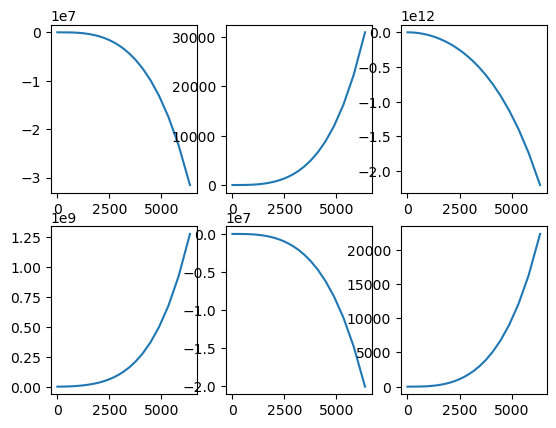

In [18]:
plot_ys(SolverInst.t, SolverInst.y)

In [32]:
solutions[0]

array([1.000e-02, 0.000e+00, 2.000e-01, 0.000e+00])

In [24]:
%load_ext cython

In [ ]:
%%cython --annotate --force
# distutils: language = c++
# cython: boundscheck=False, wraparound=False, nonecheck=False, cdivision=True, initializedcheck=False

import cython
import sys
import numpy as np
cimport numpy as np
np.import_array()

from libcpp cimport bool as bool_cpp_t
from libc.math cimport sqrt, fabs, nextafter, fmax, fmin

from CyRK.array.interp cimport interp_array, interp_complex_array
from CyRK.rk.rk cimport (
    RK23_C, RK23_B, RK23_E, RK23_A, RK23_order, RK23_error_order, RK23_n_stages, RK23_LEN_C, RK23_LEN_B, RK23_LEN_E,
    RK23_LEN_E3, RK23_LEN_E5, RK23_LEN_A0, RK23_LEN_A1,
    RK45_C, RK45_B, RK45_E, RK45_A, RK45_order, RK45_error_order, RK45_n_stages, RK45_LEN_C, RK45_LEN_B, RK45_LEN_E,
    RK45_LEN_E3, RK45_LEN_E5, RK45_LEN_A0, RK45_LEN_A1,
    DOP_C_REDUCED, DOP_B, DOP_E3, DOP_E5, DOP_A_REDUCED, DOP_order, DOP_error_order, DOP_n_stages,
    DOP_n_stages_extended, DOP_LEN_C, DOP_LEN_B, DOP_LEN_E, DOP_LEN_E3, DOP_LEN_E5, DOP_LEN_A0, DOP_LEN_A1)

# # Integration Constants
# Multiply steps computed from asymptotic behaviour of errors by this.
cdef double SAFETY = 0.9
cdef double MIN_FACTOR = 0.2  # Minimum allowed decrease in a step size.
cdef double MAX_FACTOR = 10.  # Maximum allowed increase in a step size.
cdef double MAX_STEP = np.inf
cdef double INF = np.inf
cdef double EPS = np.finfo(np.float64).eps
cdef double EPS_10 = EPS * 10.
cdef double EPS_100 = EPS * 100.
cdef Py_ssize_t MAX_INT_SIZE = int(0.95 * sys.maxsize)


cdef double cabs(double complex value) noexcept nogil:
    """ Absolute value function for complex-valued inputs.
    
    Parameters
    ----------
    value : float (double complex)
        Complex-valued number.
         
    Returns
    -------
    value_abs : float (double)
        Absolute value of `value`.
    """

    cdef double v_real
    cdef double v_imag
    v_real = value.real
    v_imag = value.imag

    return sqrt(v_real * v_real + v_imag * v_imag)

# Define fused type to handle both float and complex-valued versions of y and dydt.
ctypedef fused double_numeric:
    double
    double complex


cdef double dabs(double_numeric value) noexcept nogil:
    """ Absolute value function for either float or complex-valued inputs.
    
    Checks the type of value and either utilizes `cabs` (for double complex) or `fabs` (for floats).
    
    Parameters
    ----------
    value : float (double_numeric)
        Float or complex-valued number.

    Returns
    -------
    value_abs : float (double)
        Absolute value of `value`.
    """

    # Check the type of value
    if double_numeric is cython.doublecomplex:
        return cabs(value)
    else:
        return fabs(value)


def cyrk_ode_2(
    diffeq,
    (double, double) t_span,
    const double_numeric[:] y0,
    tuple args = None,
    double rtol = 1.e-3,
    double atol = 1.e-6,
    double[::1] rtols = None,
    double[::1] atols = None,
    double max_step = MAX_STEP,
    double first_step = 0.,
    unsigned char rk_method = 1,
    double[:] t_eval = None,
    bool_cpp_t capture_extra = False,
    Py_ssize_t num_extra = 0,
    bool_cpp_t interpolate_extra = False,
    Py_ssize_t expected_size = 0,
    Py_ssize_t max_num_steps = 0
    ):
    """
    cyrk_ode: A Runge-Kutta Solver Implemented in Cython.

    Parameters
    ----------
    diffeq : callable
        A python or njit-ed numba differential equation.
        Format should follow:
        ```
        def diffeq(t, y, dy, arg_1, arg_2, ...):
            dy[0] = y[0] * t
            ....
        ```
    t_span : (double, double)
        Values of independent variable at beginning and end of integration.
    y0 : double[::1]
        Initial values for the dependent y variables at `t_span[0]`.
    args : tuple or None, default=None
        Additional arguments used by the differential equation.
        None (default) will tell the solver to not use additional arguments.
    rk_method : int, default=1
        Runge-Kutta method that will be used. Currently implemented models:
            0: ‘RK23’: Explicit Runge-Kutta method of order 3(2).
            1: ‘RK45’ (default): Explicit Runge-Kutta method of order 5(4).
            2: ‘DOP853’: Explicit Runge-Kutta method of order 8.
    rtol : double, default=1.0e-3
        Relative tolerance using in local error calculation.
    atol : double, default=1.0e-6
        Absolute tolerance using in local error calculation.
    rtols : double[::1], default=None
        np.ndarray of relative tolerances, one for each dependent y variable.
        None (default) will use the same tolerance (set by `rtol`) for each y variable.
    atols : double[::1], default=None
        np.ndarray of absolute tolerances, one for each dependent y variable.
        None (default) will use the same tolerance (set by `atol`) for each y variable.
    max_step : double, default=+Inf
        Maximum allowed step size.
    first_step : double, default=0
        First step's size (after `t_span[0]`).
        If set to 0 (the default) then the solver will attempt to guess a suitable initial step size.
    max_num_steps : Py_ssize_t, default=0
        Maximum number of step sizes allowed before solver will auto fail.
        If set to 0 (the default) then the maximum number of steps will be equal to max integer size
        allowed on system architecture.
    t_eval : double[::1], default=None
        If not set to None, then a final interpolation will be performed on the solution to fit it to this array.
    capture_extra : bool = False
        If True, then additional output from the differential equation will be collected (but not used to determine
         integration error).
         Example:
            ```
            def diffeq(t, y, dy):
                a = ... some function of y and t.
                dy[0] = a**2 * sin(t) - y[1]
                dy[1] = a**3 * cos(t) + y[0]

                # Storing extra output in dy even though it is not part of the diffeq.
                dy[2] = a
            ```
    num_extra : int = 0
        The number of extra outputs the integrator should expect. With the previous example there is 1 extra output.
    interpolate_extra : bool_cpp_t, default=False
        Flag if interpolation should be run on extra parameters.
        If set to False when `run_interpolation=True`, then interpolation will be run on solution's y, t. These will
        then be used to recalculate extra parameters rather than an interpolation on the extra parameters captured
        during integration.
    expected_size : Py_ssize_t, default=0
        Anticipated size of integration range, i.e., how many steps will be required.
        Used to build temporary storage arrays for the solution results.
        If set to 0 (the default), then the solver will attempt to guess on a suitable expected size based on the
        relative tolerances and size of the integration domain.

    Returns
    -------
    time_domain : np.ndarray
        The final time domain. This is equal to t_eval if it was provided.
    y_results : np.ndarray
        The solution of the differential equation provided for each time_result.
    success : bool
        Final integration success flag.
    message : str
        Any integration messages, useful if success=False.
    """
    # Setup loop variables
    cdef Py_ssize_t s, i, j

    # Setup integration variables
    cdef char status, old_status
    cdef str message

    # Determine information about the differential equation based on its initial conditions
    cdef Py_ssize_t y_size
    cdef double y_size_dbl, y_size_sqrt
    cdef bool_cpp_t y_is_complex
    y_size = y0.size
    y_is_complex = False
    y_size_dbl = <double>y_size
    y_size_sqrt = sqrt(y_size_dbl)

    # Check the type of the values in y0
    if double_numeric is cython.double:
        DTYPE = np.float64
    elif double_numeric is cython.doublecomplex:
        DTYPE = np.complex128
        y_is_complex = True
    else:
        # Cyrk only supports float64 and complex128.
        status = -8
        message = "Attribute error."
        raise Exception('Unexpected type found for initial conditions (y0).')

    # Build time domain
    cdef double t_start, t_end, t_delta, t_delta_check, t_delta_abs, direction_inf, t_old, t_new, time_
    cdef bool_cpp_t direction_flag
    t_start = t_span[0]
    t_end   = t_span[1]
    t_delta = t_end - t_start
    t_delta_abs = fabs(t_delta)
    t_delta_check = t_delta_abs
    if t_delta >= 0.:
        # Integration is moving forward in time.
        direction_flag = True
        direction_inf = INF
    else:
        # Integration is moving backwards in time.
        direction_flag = False
        direction_inf = -INF

    # Pull out information on t-eval
    cdef Py_ssize_t len_teval
    if t_eval is None:
        len_teval = 0
    else:
        len_teval = t_eval.size

    # Pull out information on args
    cdef bool_cpp_t use_args
    if args is None:
        use_args = False
    else:
        use_args = True

    # Set integration flags
    cdef bool_cpp_t success, step_accepted, step_rejected, step_error, run_interpolation, \
        store_extras_during_integration
    success           = False
    step_accepted     = False
    step_rejected     = False
    step_error        = False
    run_interpolation = False
    store_extras_during_integration = capture_extra
    if len_teval > 0:
        run_interpolation = True
    if run_interpolation and not interpolate_extra:
        # If y is eventually interpolated but the extra outputs are not being interpolated, then there is
        #  no point in storing the values during the integration. Turn off this functionality to save
        #  on computation.
        store_extras_during_integration = False

    # # Determine integration tolerances
    use_arg_arrays = False
    use_atol_array = False
    cdef np.ndarray[np.float64_t, ndim=1, mode='c'] rtol_array, atol_array
    rtol_array = np.empty(y_size, dtype=np.float64, order='C')
    atol_array = np.empty(y_size, dtype=np.float64, order='C')
    cdef double[::1] rtols_view, atols_view
    rtols_view = rtol_array
    atols_view = atol_array

    if rtols is not None:
        # Using arrayed rtol
        if len(rtols) != y_size:
            raise AttributeError('rtols must be the same size as y0.')
        for i in range(y_size):
            rtol = rtols[i]
            if rtol < EPS_100:
                rtol = EPS_100
            rtols_view[i] = rtol
    else:
        # Using constant rtol
        # Check tolerances
        if rtol < EPS_100:
            rtol = EPS_100
        for i in range(y_size):
            rtols_view[i] = rtol

    if atols is not None:
        # Using arrayed atol
        if len(atols) != y_size:
            raise AttributeError('atols must be the same size as y0.')
        for i in range(y_size):
            atols_view[i] = atols[i]
    else:
        for i in range(y_size):
            atols_view[i] = atol

    # Determine maximum number of steps
    if max_num_steps == 0:
        max_num_steps = MAX_INT_SIZE
    elif max_num_steps < 0:
        raise AttributeError('Negative number of max steps provided.')
    else:
        max_num_steps = min(max_num_steps, MAX_INT_SIZE)

    # Expected size of output arrays.
    cdef double temp_expected_size
    cdef Py_ssize_t expected_size_to_use, num_concats
    if expected_size == 0:
        # CySolver will attempt to guess the best size for the output arrays.
        temp_expected_size = 100. * t_delta_abs * fmax(1., (1.e-6 / rtol))
        temp_expected_size = fmax(temp_expected_size, 100.)
        temp_expected_size = fmin(temp_expected_size, 10_000_000.)
        expected_size_to_use = <Py_ssize_t>temp_expected_size
    else:
        expected_size_to_use = <Py_ssize_t>expected_size
    # This variable tracks how many times the storage arrays have been appended.
    # It starts at 1 since there is at least one storage array present.
    num_concats = 1

    # Initialize arrays that are based on y's size and type.
    y_new    = np.empty(y_size, dtype=DTYPE, order='C')
    y_old    = np.empty(y_size, dtype=DTYPE, order='C')
    dydt_new = np.empty(y_size, dtype=DTYPE, order='C')
    dydt_old = np.empty(y_size, dtype=DTYPE, order='C')

    # Setup memory views for these arrays
    cdef double_numeric[:] y_new_view, y_old_view, dydt_new_view, dydt_old_view
    y_new_view    = y_new
    y_old_view    = y_old
    dydt_new_view = dydt_new
    dydt_old_view = dydt_old

    # Store y0 into the y arrays
    cdef double_numeric y_value
    for i in range(y_size):
        y_value = y0[i]
        y_new_view[i] = y_value
        y_old_view[i] = y_value

    # If extra output is true then the output of the diffeq will be larger than the size of y0.
    # Determine that extra size by calling the diffeq and checking its size.
    cdef Py_ssize_t extra_start, total_size, store_loop_size
    extra_start = y_size
    total_size  = y_size + num_extra
    # Create arrays based on this total size
    diffeq_out    = np.empty(total_size, dtype=DTYPE, order='C')
    y0_plus_extra = np.empty(total_size, dtype=DTYPE, order='C')
    extra_result  = np.empty(num_extra, dtype=DTYPE, order='C')

    # Setup memory views
    cdef double_numeric[:] diffeq_out_view, y0_plus_extra_view, extra_result_view
    diffeq_out_view    = diffeq_out
    y0_plus_extra_view = y0_plus_extra
    extra_result_view  = extra_result

    # Capture the extra output for the initial condition.
    if capture_extra:
        if use_args:
            diffeq(t_start, y_new, diffeq_out, *args)
        else:
            diffeq(t_start, y_new, diffeq_out)

        # Extract the extra output from the function output.
        for i in range(total_size):
            if i < extra_start:
                # Pull from y0
                y0_plus_extra_view[i] = y0[i]
            else:
                # Pull from extra output
                y0_plus_extra_view[i] = diffeq_out_view[i]
        if store_extras_during_integration:
            store_loop_size = total_size
        else:
            store_loop_size = y_size
    else:
        # No extra output
        store_loop_size = y_size

    y0_to_store = np.empty(store_loop_size, dtype=DTYPE, order='C')
    cdef double_numeric[:] y0_to_store_view
    y0_to_store_view = y0_to_store
    for i in range(store_loop_size):
        if store_extras_during_integration:
            y0_to_store_view[i] = y0_plus_extra_view[i]
        else:
            y0_to_store_view[i] = y0[i]

    # # Determine RK scheme
    cdef Py_ssize_t rk_order, error_order
    cdef Py_ssize_t rk_n_stages, rk_n_stages_plus1, rk_n_stages_extended
    cdef Py_ssize_t len_C, len_B, len_E, len_E3, len_E5, len_A0, len_A1
    cdef double error_pow, error_expo, error_norm5, error_norm3, error_norm, error_norm_abs, error_norm3_abs, error_norm5_abs, error_denom

    if rk_method == 0:
        # RK23 Method
        rk_order    = RK23_order
        error_order = RK23_error_order
        rk_n_stages = RK23_n_stages
        len_C       = RK23_LEN_C
        len_B       = RK23_LEN_B
        len_E       = RK23_LEN_E
        len_E3      = RK23_LEN_E3
        len_E5      = RK23_LEN_E5
        len_A0      = RK23_LEN_A0
        len_A1      = RK23_LEN_A1
    elif rk_method == 1:
        # RK45 Method
        rk_order    = RK45_order
        error_order = RK45_error_order
        rk_n_stages = RK45_n_stages
        len_C       = RK45_LEN_C
        len_B       = RK45_LEN_B
        len_E       = RK45_LEN_E
        len_E3      = RK45_LEN_E3
        len_E5      = RK45_LEN_E5
        len_A0      = RK45_LEN_A0
        len_A1      = RK45_LEN_A1
    elif rk_method == 2:
        # DOP853 Method
        rk_order    = DOP_order
        error_order = DOP_error_order
        rk_n_stages = DOP_n_stages
        len_C       = DOP_LEN_C
        len_B       = DOP_LEN_B
        len_E       = DOP_LEN_E
        len_E3      = DOP_LEN_E3
        len_E5      = DOP_LEN_E5
        len_A0      = DOP_LEN_A0
        len_A1      = DOP_LEN_A1

        rk_n_stages_extended = DOP_n_stages_extended
    else:
        status = -8
        message = "Attribute error."
        raise AttributeError(
            'Unexpected rk_method provided. Currently supported versions are:\n'
            '\t0 = RK23\n'
            '\t1 = RK34\n'
            '\t2 = DOP853')

    rk_n_stages_plus1 = rk_n_stages + 1
    error_expo = 1. / (<double>error_order + 1.)

    # Build RK Arrays. Note that all are 1D except for A and K.
    A      = np.empty((len_A0, len_A1), dtype=DTYPE, order='C')
    B      = np.empty(len_B, dtype=DTYPE, order='C')
    C      = np.empty(len_C, dtype=np.float64, order='C')  # C is always float no matter what y0 is.
    E      = np.empty(len_E, dtype=DTYPE, order='C')
    E3     = np.empty(len_E3, dtype=DTYPE, order='C')
    E5     = np.empty(len_E5, dtype=DTYPE, order='C')
    K      = np.zeros((rk_n_stages_plus1, y_size), dtype=DTYPE, order='C')  # It is important K be initialized with 0s

    # Setup memory views.
    cdef double_numeric[:] B_view, E_view, E3_view, E5_view
    cdef double_numeric[:, :] A_view, K_view
    cdef double_numeric A_at_sj, B_at_j, error_dot_1, error_dot_2
    cdef double[:] C_view
    A_view      = A
    B_view      = B
    C_view      = C
    E_view      = E
    E3_view     = E3
    E5_view     = E5
    K_view      = K

    # Populate values based on externally defined constants.
    if rk_method == 0:
        # RK23 Method
        for i in range(len_A0):
            for j in range(len_A1):
                A_view[i, j] = RK23_A[i][j]
        for i in range(len_B):
            B_view[i] = RK23_B[i]
        for i in range(len_C):
            C_view[i] = RK23_C[i]
        for i in range(len_E):
            E_view[i] = RK23_E[i]
            # Dummy Variables, set equal to E
            E3_view[i] = RK23_E[i]
            E5_view[i] = RK23_E[i]
    elif rk_method == 1:
        # RK45 Method
        for i in range(len_A0):
            for j in range(len_A1):
                A_view[i, j] = RK45_A[i][j]
        for i in range(len_B):
            B_view[i] = RK45_B[i]
        for i in range(len_C):
            C_view[i] = RK45_C[i]
        for i in range(len_E):
            E_view[i] = RK45_E[i]
            # Dummy Variables, set equal to E
            E3_view[i] = RK45_E[i]
            E5_view[i] = RK45_E[i]
    else:
        # DOP853 Method
        for i in range(len_A0):
            for j in range(len_A1):
                A_view[i, j] = DOP_A_REDUCED[i][j]
        for i in range(len_B):
            B_view[i] = DOP_B[i]
        for i in range(len_C):
            C_view[i] = DOP_C_REDUCED[i]
        for i in range(len_E):
            E3_view[i] = DOP_E3[i]
            E5_view[i] = DOP_E5[i]
            E_view[i] = DOP_E5[i]
            # Dummy Variables, set equal to E3
            E_view[i] = DOP_E3[i]

    # Initialize variables for start of integration
    if not capture_extra:
        # If `capture_extra` is True then this step was already performed.
        if use_args:
            diffeq(t_start, y_new, diffeq_out, *args)
        else:
            diffeq(t_start, y_new, diffeq_out)

    t_old = t_start
    t_new = t_start
    # Initialize dydt arrays.
    for i in range(y_size):
        dydt_new_view[i] = diffeq_out_view[i]
        dydt_old_view[i] = dydt_new_view[i]
    
    # Setup storage arrays
    # These arrays are built to fit a number of points equal to `expected_size_to_use`
    # If the integration needs more than that then a new array will be concatenated (with performance costs) to these.
    cdef double_numeric[:, :] y_results_array_view, y_results_array_new_view, solution_y_view
    cdef double[:] time_domain_array_view, time_domain_array_new_view, solution_t_view
    y_results_array        = np.empty((store_loop_size, expected_size_to_use), dtype=DTYPE, order='C')
    time_domain_array      = np.empty(expected_size_to_use, dtype=np.float64, order='C')
    y_results_array_view   = y_results_array
    time_domain_array_view = time_domain_array

    # Load initial conditions into output arrays
    time_domain_array_view[0] = t_start
    for i in range(store_loop_size):
        if store_extras_during_integration:
            y_results_array_view[i] = y0_plus_extra_view[i]
        else:
            y_results_array_view[i] = y0[i]

    # # Determine size of first step.
    cdef double step_size, d0, d1, d2, d0_abs, d1_abs, d2_abs, h0, h1, scale
    if first_step == 0.:
        # Select an initial step size based on the differential equation.
        # .. [1] E. Hairer, S. P. Norsett G. Wanner, "Solving Ordinary Differential
        #        Equations I: Nonstiff Problems", Sec. II.4.
        if y_size == 0:
            step_size = INF
        else:
            # Find the norm for d0 and d1
            d0 = 0.
            d1 = 0.
            for i in range(y_size):

                scale = atols_view[i] + dabs(y_old_view[i]) * rtols_view[i]
                d0_abs = dabs(y_old_view[i] / scale)
                d1_abs = dabs(dydt_old_view[i] / scale)
                d0 += (d0_abs * d0_abs)
                d1 += (d1_abs * d1_abs)

            d0 = sqrt(d0) / y_size_sqrt
            d1 = sqrt(d1) / y_size_sqrt

            if d0 < 1.e-5 or d1 < 1.e-5:
                h0 = 1.e-6
            else:
                h0 = 0.01 * d0 / d1

            if direction_flag:
                h0_direction = h0
            else:
                h0_direction = -h0
            t_new = t_old + h0_direction
            for i in range(y_size):
                y_new_view[i] = y_old_view[i] + h0_direction * dydt_old_view[i]

            if use_args:
                diffeq(t_new, y_new, diffeq_out, *args)
            else:
                diffeq(t_new, y_new, diffeq_out)

            # Find the norm for d2
            d2 = 0.
            for i in range(y_size):
                dydt_new_view[i] = diffeq_out_view[i]
                scale = atols_view[i] + dabs(y_old_view[i]) * rtols_view[i]
                d2_abs = dabs( (dydt_new_view[i] - dydt_old_view[i]) / scale)
                d2 += (d2_abs * d2_abs)

            d2 = sqrt(d2) / (h0 * y_size_sqrt)

            if d1 <= 1.e-15 and d2 <= 1.e-15:
                h1 = max(1.e-6, h0 * 1.e-3)
            else:
                h1 = (0.01 / max(d1, d2))**error_expo

            step_size = max(10. * fabs(nextafter(t_old, direction_inf) - t_old), min(100. * h0, h1))
    else:
        if first_step <= 0.:
            status = -8
            message = "Attribute error."
            raise AttributeError('Error in user-provided step size: Step size must be a positive number.')
        elif first_step > t_delta_abs:
            status = -8
            message = "Attribute error."
            raise AttributeError('Error in user-provided step size: Step size can not exceed bounds.')
        step_size = first_step

    # # Main integration loop
    cdef double min_step, step_factor, step
    cdef double c
    cdef double_numeric K_scale
    cdef Py_ssize_t len_t
    status = 0
    message = "Integration is/was ongoing (perhaps it was interrupted?)."
    len_t  = 1  # There is an initial condition provided so the time length is already 1

    if y_size == 0:
        status = -6
        message = "Integration never started: y-size is zero."

    while status == 0:
        if t_new == t_end:
            t_old = t_end
            status = 1
            break

        if len_t > max_num_steps:
            if max_num_steps == MAX_INT_SIZE:
                status = -3
                message = "Maximum number of steps (set by system architecture) exceeded during integration."
            else:
                status = -2
                message = "Maximum number of steps (set by user) exceeded during integration."
            break

        # Run RK integration step
        # Determine step size based on previous loop
        # Find minimum step size based on the value of t (less floating point numbers between numbers when t is large)
        min_step = 10. * fabs(nextafter(t_old, direction_inf) - t_old)
        # Look for over/undershoots in previous step size
        if step_size > max_step:
            step_size = max_step
        elif step_size < min_step:
            step_size = min_step

        # Determine new step size
        step_accepted = False
        step_rejected = False
        step_error    = False

        # # Step Loop
        while not step_accepted:

            if step_size < min_step:
                step_error = True
                status     = -1
                break

            # Move time forward for this particular step size
            if direction_flag:
                step = step_size
                t_new = t_old + step
                t_delta_check = t_new - t_end
            else:
                step = -step_size
                t_new = t_old + step
                t_delta_check = t_end - t_new

            # Check that we are not at the end of integration with that move
            if t_delta_check > 0.:
                t_new = t_end

                # Correct the step if we were at the end of integration
                step = t_new - t_old
                if direction_flag:
                    step_size = step
                else:
                    step_size = -step

            # Calculate derivative using RK method
            for i in range(y_size):
                K_view[0, i] = dydt_old_view[i]

            for s in range(1, len_C):
                c = C_view[s]
                time_ = t_old + c * step

                # Dot Product (K, a) * step
                for j in range(s):
                    A_at_sj = A_view[s, j]
                    for i in range(y_size):
                        if j == 0:
                            # Initialize
                            y_new_view[i] = y_old_view[i]

                        y_new_view[i] += K_view[j, i] * A_at_sj * step

                if use_args:
                    diffeq(time_, y_new, diffeq_out, *args)
                else:
                    diffeq(time_, y_new, diffeq_out)

                for i in range(y_size):
                    K_view[s, i] = diffeq_out_view[i]

            # Dot Product (K, B) * step
            for j in range(rk_n_stages):
                B_at_j = B_view[j]
                # We do not use rk_n_stages_plus1 here because we are chopping off the last row of K to match
                #  the shape of B.
                for i in range(y_size):
                    if j == 0:
                        # Initialize
                        y_new_view[i] = y_old_view[i]
                    y_new_view[i] += K_view[j, i] * B_at_j * step

            if use_args:
                diffeq(t_new, y_new, diffeq_out, *args)
            else:
                diffeq(t_new, y_new, diffeq_out)

            if rk_method == 2:
                # Calculate Error for DOP853
                # Find norms for each error
                error_norm5 = 0.
                error_norm3 = 0.
                # Dot Product (K, E5) / scale and Dot Product (K, E3) * step / scale
                for i in range(y_size):
                    # Find scale of y for error calculations
                    scale = (atols_view[i] + max(dabs(y_old_view[i]), dabs(y_new_view[i])) * rtols_view[i])

                    # Set diffeq results
                    dydt_new_view[i] = diffeq_out_view[i]

                    # Set last array of K equal to dydt
                    K_view[rk_n_stages, i] = dydt_new_view[i]
                    for j in range(rk_n_stages_plus1):
                        if j == 0:
                            # Initialize
                            error_dot_1 = 0.
                            error_dot_2 = 0.

                        K_scale = K_view[j, i] / <double_numeric>scale
                        error_dot_1 += K_scale * E3_view[j]
                        error_dot_2 += K_scale * E5_view[j]

                    error_norm3_abs = dabs(error_dot_1)
                    error_norm5_abs = dabs(error_dot_2)

                    error_norm3 += (error_norm3_abs * error_norm3_abs)
                    error_norm5 += (error_norm5_abs * error_norm5_abs)

                # Check if errors are zero
                if (error_norm5 == 0.) and (error_norm3 == 0.):
                    error_norm = 0.
                else:
                    error_denom = error_norm5 + 0.01 * error_norm3
                    error_norm = step_size * error_norm5 / sqrt(error_denom * y_size_dbl)

            else:
                # Calculate Error for RK23 and RK45
                # Dot Product (K, E) * step / scale
                error_norm = 0.
                for i in range(y_size):
                    # Find scale of y for error calculations
                    scale = (atols_view[i] + max(dabs(y_old_view[i]), dabs(y_new_view[i])) * rtols_view[i])

                    # Set diffeq results
                    dydt_new_view[i] = diffeq_out_view[i]

                    # Set last array of K equal to dydt
                    K_view[rk_n_stages, i] = dydt_new_view[i]
                    for j in range(rk_n_stages_plus1):
                        if j == 0:
                            # Initialize
                            error_dot_1 = 0.

                        K_scale = K_view[j, i] / <double_numeric>scale
                        error_dot_1 += K_scale * E_view[j] * step

                    error_norm_abs = dabs(error_dot_1)
                    error_norm += (error_norm_abs * error_norm_abs)
                error_norm = sqrt(error_norm) / y_size_sqrt

            if error_norm < 1.:
                # The error is low! Let's update this step for the next time loop
                if error_norm == 0.:
                    step_factor = MAX_FACTOR
                else:
                    error_pow = error_norm**-error_expo
                    step_factor = min(MAX_FACTOR, SAFETY * error_pow)

                if step_rejected:
                    # There were problems with this step size on the previous step loop. Make sure factor does
                    #    not exasperate them.
                    step_factor = min(step_factor, 1.)

                step_size = step_size * step_factor
                step_accepted = True
            else:
                error_pow = error_norm**-error_expo
                step_size = step_size * max(MIN_FACTOR, SAFETY * error_pow)
                step_rejected = True

        if step_error:
            # Issue with step convergence
            status = -1
            message = "Error in step size calculation:\n\tRequired step size is less than spacing between numbers."
            break
        elif not step_accepted:
            # Issue with step convergence
            status = -7
            message = "Error in step size calculation:\n\tError in step size acceptance."
            break

        # End of step loop. Update the _now variables
        t_old = t_new
        for i in range(y_size):
            y_old_view[i] = y_new_view[i]
            dydt_old_view[i] = dydt_new_view[i]

        # Save data
        if len_t >= (num_concats * expected_size_to_use):                
            # There is more data than we have room in our arrays. 
            # Build new arrays with more space.
            # OPT: Note this is an expensive operation. 
            num_concats += 1
            new_size = num_concats * expected_size_to_use
            time_domain_array_new      = np.empty(new_size, dtype=np.float64, order='C')
            y_results_array_new        = np.empty((store_loop_size, new_size), dtype=DTYPE, order='C')
            time_domain_array_new_view = time_domain_array_new
            y_results_array_new_view   = y_results_array_new
            
            # Loop through time to fill in these new arrays with the old values
            for i in range(len_t):
                time_domain_array_new_view[i] = time_domain_array_view[i]
                
                for j in range(store_loop_size):
                    y_results_array_new_view[j, i] = y_results_array_view[j, i]
            
            # No longer need the old arrays. Change where the view is pointing and delete them.
            y_results_array_view = y_results_array_new
            time_domain_array_view = time_domain_array_new
            # TODO: Delete the old arrays?
        
        # There should be room in the arrays to add new data.
        time_domain_array_view[len_t] = t_new
        # To match the format that scipy follows, we will take the transpose of y.
        for i in range(store_loop_size):
            if i < extra_start:
                # Pull from y result
                y_results_array_view[i, len_t] = y_new_view[i]
            else:
                # Pull from extra
                y_results_array_view[i, len_t] = extra_result_view[i - extra_start]

        # Increase number of time points.
        len_t += 1

    # # Clean up output.
    if status == 1:
        success = True
        message = "Integration completed without issue."

    # Create output arrays. To match the format that scipy follows, we will take the transpose of y.
    if success:
        # Build final output arrays.
        # The arrays built during integration likely have a bunch of unused junk at the end due to overbuilding their size.
        # This process will remove that junk and leave only the wanted data.
        solution_y = np.empty((store_loop_size, len_t), dtype=DTYPE, order='C')
        solution_t = np.empty(len_t, dtype=np.float64, order='C')

        # Link memory views
        solution_y_view = solution_y
        solution_t_view = solution_t

        # Populate values
        for i in range(len_t):
            solution_t_view[i] = time_domain_array_view[i]
            for j in range(store_loop_size):
                solution_y_view[j, i] = y_results_array_view[j, i]
    else:
        # Build nan arrays
        solution_y = np.nan * np.ones((store_loop_size, 1), dtype=DTYPE, order='C')
        solution_t = np.nan * np.ones(1, dtype=np.float64, order='C')

        # Link memory views
        solution_y_view = solution_y
        solution_t_view = solution_t

    cdef double_numeric[:, :] y_results_reduced_view
    cdef double_numeric[:] y_result_timeslice_view, y_result_temp_view, y_interp_view

    if run_interpolation and success:
        old_status = status
        status = 2
        # User only wants data at specific points.

        # The current version of this function has not implemented sicpy's dense output.
        #   Instead we use an interpolation.
        # OPT: this could be done inside the integration loop for performance gains.
        y_results_reduced       = np.empty((total_size, len_teval), dtype=DTYPE, order='C')
        y_result_timeslice      = np.empty(len_t, dtype=DTYPE, order='C')
        y_result_temp           = np.empty(len_teval, dtype=DTYPE, order='C')
        y_results_reduced_view  = y_results_reduced
        y_result_timeslice_view = y_result_timeslice
        y_result_temp_view      = y_result_temp

        for j in range(y_size):
            # np.interp only works on 1D arrays so we must loop through each of the variables:
            # # Set timeslice equal to the time values at this y_j
            for i in range(len_t):
                y_result_timeslice_view[i] = solution_y_view[j, i]

            # Perform numerical interpolation
            if double_numeric is cython.doublecomplex:
                interp_complex_array(
                    t_eval,
                    solution_t_view,
                    y_result_timeslice_view,
                    y_result_temp_view
                    )
            else:
                interp_array(
                    t_eval,
                    solution_t_view,
                    y_result_timeslice_view,
                    y_result_temp_view
                    )

            # Store result.
            for i in range(len_teval):
                y_results_reduced_view[j, i] = y_result_temp_view[i]

        if capture_extra:
            # Right now if there is any extra output then it is stored at each time step used in the RK loop.
            # We have to make a choice on what to output do we, like we do with y, interpolate all of those extras?
            #  or do we use the interpolation on y to find new values.
            # The latter method is more computationally expensive (recalls the diffeq for each y) but is more accurate.
            if interpolate_extra:
                # Continue the interpolation for the extra values.
                for j in range(num_extra):
                    # np.interp only works on 1D arrays so we must loop through each of the variables:
                    # # Set timeslice equal to the time values at this y_j
                    for i in range(len_t):
                        y_result_timeslice_view[i] = solution_y_view[extra_start + j, i]

                    # Perform numerical interpolation
                    if double_numeric is cython.doublecomplex:
                        interp_complex_array(
                                t_eval,
                                solution_t_view,
                                y_result_timeslice_view,
                                y_result_temp_view
                                )
                    else:
                        interp_array(
                                t_eval,
                                solution_t_view,
                                y_result_timeslice_view,
                                y_result_temp_view
                                )

                    # Store result.
                    for i in range(len_teval):
                        y_results_reduced_view[extra_start + j, i] = y_result_temp_view[i]
            else:
                # Use y and t to recalculate the extra outputs
                y_interp = np.empty(y_size, dtype=DTYPE)
                y_interp_view = y_interp
                for i in range(len_teval):
                    time_ = t_eval[i]
                    for j in range(y_size):
                        y_interp_view[j] = y_results_reduced_view[j, i]

                    if use_args:
                        diffeq(time_, y_interp, diffeq_out, *args)
                    else:
                        diffeq(time_, y_interp, diffeq_out)

                    for j in range(num_extra):
                        y_results_reduced_view[extra_start + j, i] = diffeq_out_view[extra_start + j]

        # Replace the output y results and time domain with the new reduced one
        solution_y = np.empty((total_size, len_teval), dtype=DTYPE, order='C')
        solution_t = np.empty(len_teval, dtype=np.float64, order='C')
        solution_y_view = solution_y
        solution_t_view = solution_t

        # Update output arrays
        for i in range(len_teval):
            solution_t_view[i] = t_eval[i]
            for j in range(total_size):
                # To match the format that scipy follows, we will take the transpose of y.
                solution_y_view[j, i] = y_results_reduced_view[j, i]
        status = old_status

    return solution_t, solution_y, success, message



In [209]:
frequency_prime = 1.0e-5


In [224]:
out_cy_HighRes = cyrk_ode_2(
        dynamic_liquid_ode_cy,
        (radius_prime[0], radius_prime[-1]),
        solutions[0],
        args=(radius_prime, bulk_modulus_prime, density_prime, gravity_prime, frequency_prime, order_l, newton_g_prime, False),
        rtol=1.0e-9, atol=1.0e-10,
        rk_method=1)


print('\n\n\n')
print(out_cy_HighRes[2])
print(out_cy_HighRes[3])
print(out_cy_HighRes[0].shape)
print(out_cy_HighRes[1].shape)





True
Integration completed without issue.
(1347577,)
(8, 1347577)


In [211]:
out_cy_2 = cyrk_ode_2(
        dynamic_liquid_ode_cy,
        (radius_prime[0], radius_prime[-1]),
        solutions[0],
        args=(radius_prime, bulk_modulus_prime, density_prime, gravity_prime, frequency_prime, order_l, newton_g_prime, False),
        rtol=1.0e-2, atol=1.0e-5,
        rk_method=2)


print('\n\n\n')
print(out_cy_2[2])
print(out_cy_2[3])
print(out_cy_2[0].shape)
print(out_cy_2[1].shape)





True
Integration completed without issue.
(1470,)
(8, 1470)


In [244]:
rtols = 1.0e-3 * np.ones(solutions[0].size, dtype=np.float64, order='C')
rtols[2] = 1.0e-4

out_cy_3 = cyrk_ode_2(dynamic_liquid_ode_cy, (radius_prime[0], radius_prime[-1]), solutions[0], args=(radius_prime, bulk_modulus_prime, density_prime, gravity_prime, frequency_prime, order_l, newton_g_prime, False), rtol=1.0e-4, atol=1.0e-5, rtols=rtols, rk_method=1)
%timeit cyrk_ode_2(dynamic_liquid_ode_cy, (radius_prime[0], radius_prime[-1]), solutions[0], args=(radius_prime, bulk_modulus_prime, density_prime, gravity_prime, frequency_prime, order_l, newton_g_prime, False), rtol=1.0e-4, atol=1.0e-5, rtols=rtols, rk_method=1)


print('\n\n\n')
print(out_cy_3[2])
print(out_cy_3[3])
print(out_cy_3[0].shape)
print(out_cy_3[1].shape)

327 ms ± 7.77 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)




True
Integration completed without issue.
(3257,)
(8, 3257)


In [225]:

for i in range(out_cy_HighRes[1].shape[0]):
    print()
    print('y', i)
    print(out_cy_HighRes[1][i, -1])
    print(out_cy_2[1][i, -1], 100 * np.abs(out_cy_HighRes[1][i, -1] - out_cy_2[1][i, -1])/out_cy_HighRes[1][i, -1])
    print(out_cy_3[1][i, -1], 100 * np.abs(out_cy_HighRes[1][i, -1] - out_cy_3[1][i, -1])/out_cy_HighRes[1][i, -1])


y 0
5.053463039696809e+259
9.219414813875295e+259 82.43756294353798
5.1430393172547565e+259 1.7725721323039811

y 1
0.0
0.0 nan
0.0 nan

y 2
2.7209674576030303e+264
4.964069084987715e+264 82.43764992914285
2.769198640025215e+264 1.772574761503133

y 3
0.0
0.0 nan
0.0 nan

y 4
1.6000249859103832e+256
2.9174891169050944e+256 82.34022234628415
1.62837177378237e+256 1.7716465756225728

y 5
0.0
0.0 nan
0.0 nan

y 6
-2.3232512291601736e+254
-4.238484920608668e+254 -82.43764890380916
-2.364432593865349e+254 -1.772574751636389

y 7
0.0
0.0 nan
0.0 nan


In [9]:
%%cython --annotate --force
# distutils: language = c++

from libcpp cimport bool as cpp_bool_t
import numpy as np
cimport numpy as np

from scipy.constants import G as G_
from TidalPy.radial_solver.nondimensional import non_dimensionalize_physicals, re_dimensionalize_radial_func
from TidalPy.radial_solver.numerical.collapse import collapse_solutions
from TidalPy.radial_solver.numerical.initial import find_initial_guess
from TidalPy.radial_solver.numerical.interfaces import find_interface_func

# Import cythonized functions
from TidalPy.radial_solver.numerical.interfaces.interfaces_x cimport find_solution_num


# Setup globals
cdef double G
G = G_


def radial_solver_x(double[:] radius_array,
                    double complex[:] complex_shear_array,
                    double[:] bulk_array,
                    double[:] density_array,
                    double[:] gravity_array,
                    double frequency,
                    double planet_bulk_density,
                    tuple is_solid_by_layer,
                    tuple is_static_by_layer,
                    tuple is_incompressible_by_layer,
                    tuple indices_by_layer,
                    unsigned int degree_l = 2, 
                    double complex[:] surface_boundary_conditions = None,
                    cpp_bool_t solve_load_numbers = False,
                    cpp_bool_t use_kamata = False,
                    int integration_method = 1,
                    double integration_rtol = 1.0e-8,
                    double integration_atol = 1.0e-9, 
                    cpp_bool_t verbose = False,
                    cpp_bool_t nondimensionalize = True,
                    ):
    # General indexing
    cdef Py_ssize_t i, j, filled_j
    
    # Pull out key information
    cdef double radius_planet
    cdef Py_ssize_t num_layers, num_interfaces, num_radius
    radius_planet  = radius_array[-1]
    # TODO: Exception to check if there is at least one layer?
    num_layers     = len(is_solid_by_layer)
    num_interfaces = num_layers - 1
    num_radius     = len(radius_array)
    
    # Non-dimensionalize inputs
    cdef double G_to_use
    
    if nondimensionalize:
        radius_array, gravity_array, density_array, complex_shear_array, bulk_array, frequency, G_to_use = \
            non_dimensionalize_physicals(
                    radius_array, gravity_array, density_array, complex_shear_array, bulk_array, frequency,
                    mean_radius=radius_planet, bulk_density=planet_bulk_density
                    )
    else:
        G_to_use = G
    
    # Find boundary condition at the top of the planet -- this is dependent on the forcing type.
    #     Tides (default here) follow the (y2, y4, y6) = (0, 0, (2l+1)/R) rule
    cdef np.ndarray[np.complex128_t, ndim=1] bc_array
    cdef double complex[:] bc_array_view
    bc_array = np.empty(3, dtype=np.complex128)
    bc_array_view = bc_array
    
    if surface_boundary_conditions is None:
        # Assume tides
        for i in range(3):
            if i == 2:
                if nondimensionalize:
                    bc_array_view[i] == (2. * degree_l + 1.) / 1.
                else:
                    bc_array_view[i] == (2. * degree_l + 1.) / radius_planet
    else:
        # Use user input
        # TODO: Exception if user input is wrong size.
        for i in range(3):
            bc_array_view[i] = surface_boundary_conditions[i]
    
    # Find number of solutions per layer
    cdef np.ndarray[np.uint16_t, ndim=1] num_solutions_by_layer_array
    cdef unsigned short num_solutions_by_layer_view
    num_solutions_by_layer_array = np.zeros(num_layers, dtype=np.ushort)
    num_solutions_by_layer_view = num_solutions_by_layer_array
    
    cdef np.ndarray[np.uint8_t, ndim=2] indices_by_layer_array
    cdef unsigned char[:, :] indices_by_layer_view
    indices_by_layer_array = np.zeros((num_layers, num_radius), dtype=np.uint8)
    indices_by_layer_view = indices_by_layer_array
    
    cdef Py_ssize_t num_radius_in_layer
    cdef np.ndarray[np.uint32_t, ndim=1] layer_length_array
    cdef unsigned int[:] layer_length_view
    layer_length_array = np.zeros(num_layers, dtype=np.uint32)
    layer_length_view = layer_length_array
    
    cdef cpp_bool_t layer_is_solid, layer_is_static, layer_is_incomp
    
    for i in range(num_layers):
        
        layer_is_solid = is_solid_by_layer[i]
        layer_is_static = is_static_by_layer[i]
        layer_is_incomp = is_incompressible_by_layer[i]
        
        num_solutions_by_layer_array[i] = find_solution_num(layer_is_solid, layer_is_static, layer_is_incomp)
        
        # Determine which radii fall within this layer
        num_radius_in_layer = 0
        for j in range(num_radius):
            if indices_by_layer[i][j] == 1:
                indices_by_layer_view[i, j] = 1
                num_radius_in_layer += 1
        layer_length_view[i] = <unsigned int>num_radius_in_layer
                
        
    
    # Store solutions per layer.
    # TODO: Make this a ndarray?
    cdef list solutions_by_layer_list
    solutions_by_layer_list = list()
    
    # Other variables
    cdef np.ndarray[np.float64_t, ndim=1] layer_radii_array, layer_bulk_array, layer_density_array, layer_gravity_array
    cdef np.ndarray[np.complex128_t, ndim=1] layer_shear_array
    cdef double[:] layer_radii_view, layer_bulk_view, layer_density_view, layer_gravity_view
    cdef double complex[:] layer_shear_view
    
    cdef np.ndarray[np.complex128_t, ndim=2] solutions_below_array
    cdef double complex[:, :] solutions_below_view
    
    cdef double layer_radius_lower, layer_radius_upper
    cdef double layer_gravity_lower, layer_gravity_upper
    cdef double layer_density_lower, layer_bulk_lower
    cdef double complex layer_shear_lower
    
    cdef Py_ssize_t n_layer_radius
    cdef unsigned short layer_num_solutions
    
    # # Main Solution Loop
    # Ready to solve the viscoelastic-gravitational problem for each layer, obtaining multiple solutions per layer
    #  which will later be collapsed via a linear combination (subjected to boundary conditions) into a single
    #  solution for the entire planet.
    
    # Loop through layers from bottom to top and solve the differential equations
    for i in range(num_layers):
        
        # Pull out layer information
        num_radius_in_layer = <Py_ssize_t>layer_length_view[i]
        # Build arrays filled with this layer's properties
        layer_radii_array   = np.empty(num_radius_in_layer, dtype=np.float64)
        layer_bulk_array    = np.empty(num_radius_in_layer, dtype=np.float64)
        layer_density_array = np.empty(num_radius_in_layer, dtype=np.float64)
        layer_gravity_array = np.empty(num_radius_in_layer, dtype=np.float64)
        layer_shear_array   = np.empty(num_radius_in_layer, dtype=np.complex128)
        layer_radii_view    = layer_radii_array
        layer_bulk_view     = layer_bulk_array
        layer_density_view  = layer_density_array
        layer_gravity_view  = layer_gravity_array
        layer_shear_view    = layer_shear_array
        filled_j = 0
        for j in range(num_radius):
            if indices_by_layer_view[i, j] == 1:
                layer_radii_view[filled_j]   = radius_array[j]
                layer_bulk_view[filled_j]    = bulk_array[j]
                layer_density_view[filled_j] = density_array[j]
                layer_gravity_view[filled_j] = gravity_array[j]
                layer_shear_view[filled_j]   = complex_shear_array[j]
                filled_j += 1
        
        # Get properties at the base of the layer
        layer_shear_lower   = layer_shear_view[0]
        layer_bulk_lower    = layer_bulk_view[0]
        layer_density_lower = layer_density_view[0]
        layer_gravity_lower = layer_gravity_view[0]
        layer_radius_lower  = layer_radii_view[0]
        
        # Get properties at the top of the layer
        layer_radius_upper  = layer_radii_view[num_radius_in_layer - 1]
        layer_gravity_upper = layer_gravity_view[num_radius_in_layer - 1]
        
        # Get physical state of layer
        layer_is_solid      = is_solid_by_layer[i]
        layer_is_static     = is_static_by_layer[i]
        layer_is_incomp     = is_incompressible_by_layer[i]
        
        # Get integration information for layer
        layer_num_solutions = num_solutions_by_layer_array[i]
        
        # Find initial conditions at bottom of layer
        if i == 0:
            # Use initial condition function
            find_initial_guess(
                        layer_is_solid, layer_is_static, layer_is_incomp, use_kamata,
                        layer_radius_lower, layer_shear_lower, layer_bulk_lower, layer_density_lower, frequency,
                        order_l=degree_l, G_to_use=G_to_use
                        )
        else:
            # Use results at the top of the layer below and a interface function
            pass
            
            
            
    
            
            
        
    


Error compiling Cython file:
------------------------------------------------------------
...
        # Find initial conditions at bottom of layer
        if i == 0:
            # Use initial condition function
            find_initial_guess(
                        layer_is_solid, layer_is_static, layer_is_incomp, use_kamata,
                        layer_radius_lower, shear_modulus[0], bulk_modulus[0], density[0], frequency,
                                            ^
------------------------------------------------------------

C:\Users\joepr\.ipython\cython\_cython_magic_87277e562a4163a37047c1ee421551f5937e9b7b.pyx:202:44: undeclared name not builtin: shear_modulus

Error compiling Cython file:
------------------------------------------------------------
...
        # Find initial conditions at bottom of layer
        if i == 0:
            # Use initial condition function
            find_initial_guess(
                        layer_is_solid, layer_is_static, layer_is_incomp, u

In [23]:
x = np.linspace(0., 3., 4)
y = x <= 2.
print(x, y)
f(y)

[0.000e+00 1.000e+00 2.000e+00 3.000e+00] [ True  True  True False]
Yes!
Yes!
Yes!
No :(
